# Dicom to Nifti CTs and masks

In [5]:
import os
import pydicom
import pydicom_seg
import pandas as pd
import SimpleITK as sitk

from glob import glob
from tqdm import tqdm


raw_data_path = 'NSCLC-Radiomics/'

data = pd.read_csv('metadata.csv')  # This file should be created by NBIA Data Retriever
data["SeriesInstanceUID"] = data["Series UID"]
data["StudyUID"] = data["Study UID"]
data["FileLocation"] = data["File Location"]
patient_ids = data["Subject ID"].unique()

img_reader = sitk.ImageSeriesReader()
seg_reader = pydicom_seg.SegmentReader()

for pid in tqdm(patient_ids):

    row = data[data["Subject ID"] == pid]
    out_fn = f'NSCLC-Radiomics-NIFTI/{pid}'
    
    
    pid_for_save = 'NSCLC_'+str(pid.split('-')[-1])+'_0000.nii.gz'

    os.makedirs(out_fn,exist_ok=True)
    raw_data_path     = f'NSCLC-Radiomics/{pid}'
    dicom_series_path = row[row['Modality'] == 'CT'].StudyUID.values[0] +'/'+row[row['Modality'] == 'CT'].SeriesInstanceUID.values[0]
    dicom_series_path = os.path.join(raw_data_path, dicom_series_path)
    
    
    dicom_names = img_reader.GetGDCMSeriesFileNames(dicom_series_path)
    img_reader.SetFileNames(dicom_names)
    image = img_reader.Execute()

    sitk.WriteImage(image, os.path.join(out_fn,  pid_for_save), True)

    if pid == 'LUNG1-128': continue  # LUNG1-128 missing segmentation

    
    dicom_seg_series_path = row[row['Modality'] == 'SEG'].StudyUID.values[0] +'/'+row[row['Modality'] == 'SEG'].SeriesInstanceUID.values[0]
    dicom_seg_series_path = os.path.join(raw_data_path, dicom_seg_series_path)
    dicom_names = img_reader.GetGDCMSeriesFileNames(dicom_seg_series_path)
    dcm = pydicom.dcmread(dicom_names[0])
    result = seg_reader.read(dcm)

    for segment_number in result.available_segments:
        image = result.segment_image(segment_number)  # lazy construction
        sitk.WriteImage(image, os.path.join(out_fn, f'seg-{result.segment_infos[segment_number].SegmentDescription}.nii.gz'), True)


  3%|████████▌                                                                                                                                                                                                                                                                            | 13/422 [04:26<2:28:13, 21.74s/it]WARNING: In /tmp/SimpleITK-build/ITK-prefix/include/ITK-5.1/itkImageSeriesReader.hxx, line 480
ImageSeriesReader (0x559958e35790): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.44186

  5%|█████████████▏                                                                                                                                                                                                                                                                       | 20/422 [06:35<2:13:27, 19.92s/it]WARNING: In /tmp/SimpleITK-build/ITK-prefix/include/ITK-5.1/itkImageSeriesReader.hxx, line 480
ImageSeriesReader (0x559958e35790): Non uniform sampling or

# Combine-Masks

In [6]:
import os
import SimpleITK as sitk
import numpy as np

from glob import glob
from tqdm import tqdm


def combine_segmentations(folder, output_filename="segmentation.nii.gz"):
    """
    Combines multiple single-label segmentation files into a single multi-label segmentation file.

    Args:
        folder (str): Path to the folder containing segmentation files.
        output_filename (str): Name of the combined multi-label segmentation file.
    """
    # Define the segmentation file names and their corresponding labels
    segmentation_labels = {
        "seg-Esophagus.nii.gz": 1,
        "seg-GTV-1.nii.gz": 2,
        "seg-Heart.nii.gz": 3,
        "seg-Lung-Left.nii.gz": 4,
        "seg-Lung-Right.nii.gz": 5,
        "seg-Spinal-Cord.nii.gz": 6,
    }

    # Initialize an empty image for combining segmentations
    combined_image = None

    for seg_file, label in segmentation_labels.items():
        seg_path = os.path.join(folder, seg_file)

        if os.path.exists(seg_path):
            # Read the segmentation file
            seg_image = sitk.ReadImage(seg_path)

            # Convert to numpy array
            seg_array = sitk.GetArrayFromImage(seg_image)

            # Create a binary mask for the current label
            binary_mask = (seg_array > 0).astype(np.uint8) * label

            if combined_image is None:
                # Initialize the combined image with the same size and spacing as the first segmentation
                combined_array = np.zeros_like(seg_array, dtype=np.uint8)
                combined_image = seg_image

            # Add the current binary mask to the combined array (ensuring no label overlap)
            combined_array = np.maximum(combined_array, binary_mask)

    if combined_image is not None:
        # Set the combined array as the new image's data
        combined_image = sitk.GetImageFromArray(combined_array)
        combined_image.CopyInformation(seg_image)

        # Save the combined multi-label segmentation file
        output_path = os.path.join(folder, output_filename)
        sitk.WriteImage(combined_image, output_path)

        print(f"Combined multi-label segmentation saved at: {output_path}")
    else:
        print("No segmentation files found to combine.")


folders = sorted(glob(f'/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/*'))

for fd in tqdm(folders):
    combine_segmentations(fd)


  0%|▋                                                                                                                                                                                                                                                                                       | 1/422 [00:01<09:12,  1.31s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-001/segmentation.nii.gz


  0%|█▎                                                                                                                                                                                                                                                                                      | 2/422 [00:02<08:51,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-002/segmentation.nii.gz


  1%|█▉                                                                                                                                                                                                                                                                                      | 3/422 [00:03<08:31,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-003/segmentation.nii.gz


  1%|██▋                                                                                                                                                                                                                                                                                     | 4/422 [00:04<08:21,  1.20s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-004/segmentation.nii.gz


  1%|███▎                                                                                                                                                                                                                                                                                    | 5/422 [00:06<08:19,  1.20s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-005/segmentation.nii.gz


  1%|███▉                                                                                                                                                                                                                                                                                    | 6/422 [00:07<08:31,  1.23s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-006/segmentation.nii.gz


  2%|████▋                                                                                                                                                                                                                                                                                   | 7/422 [00:08<09:20,  1.35s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-007/segmentation.nii.gz


  2%|█████▎                                                                                                                                                                                                                                                                                  | 8/422 [00:10<09:20,  1.35s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-008/segmentation.nii.gz


  2%|█████▉                                                                                                                                                                                                                                                                                  | 9/422 [00:11<08:30,  1.24s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-009/segmentation.nii.gz


  2%|██████▌                                                                                                                                                                                                                                                                                | 10/422 [00:12<08:00,  1.17s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-010/segmentation.nii.gz


  3%|███████▎                                                                                                                                                                                                                                                                               | 11/422 [00:13<07:38,  1.12s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-011/segmentation.nii.gz


  3%|███████▉                                                                                                                                                                                                                                                                               | 12/422 [00:14<07:45,  1.14s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-012/segmentation.nii.gz


  3%|████████▌                                                                                                                                                                                                                                                                              | 13/422 [00:15<07:55,  1.16s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-013/segmentation.nii.gz


  3%|█████████▎                                                                                                                                                                                                                                                                             | 14/422 [00:17<08:49,  1.30s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-014/segmentation.nii.gz


  4%|█████████▉                                                                                                                                                                                                                                                                             | 15/422 [00:18<08:07,  1.20s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-015/segmentation.nii.gz


  4%|██████████▌                                                                                                                                                                                                                                                                            | 16/422 [00:19<07:37,  1.13s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-016/segmentation.nii.gz


  4%|███████████▏                                                                                                                                                                                                                                                                           | 17/422 [00:20<07:36,  1.13s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-017/segmentation.nii.gz


  4%|███████████▉                                                                                                                                                                                                                                                                           | 18/422 [00:21<07:26,  1.11s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-018/segmentation.nii.gz


  5%|████████████▌                                                                                                                                                                                                                                                                          | 19/422 [00:22<07:14,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-019/segmentation.nii.gz


  5%|█████████████▏                                                                                                                                                                                                                                                                         | 20/422 [00:23<07:24,  1.10s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-020/segmentation.nii.gz


  5%|█████████████▉                                                                                                                                                                                                                                                                         | 21/422 [00:26<09:59,  1.50s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-021/segmentation.nii.gz


  5%|██████████████▌                                                                                                                                                                                                                                                                        | 22/422 [00:27<09:32,  1.43s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-022/segmentation.nii.gz


  5%|███████████████▏                                                                                                                                                                                                                                                                       | 23/422 [00:28<09:25,  1.42s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-023/segmentation.nii.gz


  6%|███████████████▊                                                                                                                                                                                                                                                                       | 24/422 [00:29<08:47,  1.33s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-024/segmentation.nii.gz


  6%|████████████████▌                                                                                                                                                                                                                                                                      | 25/422 [00:31<08:36,  1.30s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-025/segmentation.nii.gz


  6%|█████████████████▏                                                                                                                                                                                                                                                                     | 26/422 [00:32<08:15,  1.25s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-026/segmentation.nii.gz


  6%|█████████████████▊                                                                                                                                                                                                                                                                     | 27/422 [00:33<07:35,  1.15s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-027/segmentation.nii.gz


  7%|██████████████████▌                                                                                                                                                                                                                                                                    | 28/422 [00:34<07:33,  1.15s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-028/segmentation.nii.gz


  7%|███████████████████▏                                                                                                                                                                                                                                                                   | 29/422 [00:35<07:49,  1.19s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-029/segmentation.nii.gz


  7%|███████████████████▊                                                                                                                                                                                                                                                                   | 30/422 [00:36<07:29,  1.15s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-030/segmentation.nii.gz


  7%|████████████████████▍                                                                                                                                                                                                                                                                  | 31/422 [00:38<08:49,  1.35s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-031/segmentation.nii.gz


  8%|█████████████████████▏                                                                                                                                                                                                                                                                 | 32/422 [00:39<08:26,  1.30s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-032/segmentation.nii.gz


  8%|█████████████████████▊                                                                                                                                                                                                                                                                 | 33/422 [00:40<08:19,  1.28s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-033/segmentation.nii.gz


  8%|██████████████████████▍                                                                                                                                                                                                                                                                | 34/422 [00:41<07:52,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-034/segmentation.nii.gz


  8%|███████████████████████▏                                                                                                                                                                                                                                                               | 35/422 [00:42<07:29,  1.16s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-035/segmentation.nii.gz


  9%|███████████████████████▊                                                                                                                                                                                                                                                               | 36/422 [00:44<07:37,  1.19s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-036/segmentation.nii.gz


  9%|████████████████████████▍                                                                                                                                                                                                                                                              | 37/422 [00:45<07:17,  1.14s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-037/segmentation.nii.gz


  9%|█████████████████████████                                                                                                                                                                                                                                                              | 38/422 [00:47<09:13,  1.44s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-038/segmentation.nii.gz


  9%|█████████████████████████▊                                                                                                                                                                                                                                                             | 39/422 [00:48<08:45,  1.37s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-039/segmentation.nii.gz


  9%|██████████████████████████▍                                                                                                                                                                                                                                                            | 40/422 [00:49<08:25,  1.32s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-040/segmentation.nii.gz


 10%|███████████████████████████                                                                                                                                                                                                                                                            | 41/422 [00:50<07:51,  1.24s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-041/segmentation.nii.gz


 10%|███████████████████████████▊                                                                                                                                                                                                                                                           | 42/422 [00:51<07:38,  1.21s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-042/segmentation.nii.gz


 10%|████████████████████████████▍                                                                                                                                                                                                                                                          | 43/422 [00:53<07:26,  1.18s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-043/segmentation.nii.gz


 10%|█████████████████████████████                                                                                                                                                                                                                                                          | 44/422 [00:53<06:57,  1.10s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-044/segmentation.nii.gz


 11%|█████████████████████████████▊                                                                                                                                                                                                                                                         | 45/422 [00:54<06:40,  1.06s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-045/segmentation.nii.gz


 11%|██████████████████████████████▍                                                                                                                                                                                                                                                        | 46/422 [00:55<06:32,  1.04s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-046/segmentation.nii.gz


 11%|███████████████████████████████                                                                                                                                                                                                                                                        | 47/422 [00:56<06:29,  1.04s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-047/segmentation.nii.gz


 11%|███████████████████████████████▋                                                                                                                                                                                                                                                       | 48/422 [00:58<06:56,  1.11s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-048/segmentation.nii.gz


 12%|████████████████████████████████▍                                                                                                                                                                                                                                                      | 49/422 [00:59<06:42,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-049/segmentation.nii.gz


 12%|█████████████████████████████████                                                                                                                                                                                                                                                      | 50/422 [00:59<05:29,  1.13it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-050/segmentation.nii.gz


 12%|█████████████████████████████████▋                                                                                                                                                                                                                                                     | 51/422 [01:01<06:24,  1.04s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-051/segmentation.nii.gz


 12%|██████████████████████████████████▍                                                                                                                                                                                                                                                    | 52/422 [01:02<06:35,  1.07s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-052/segmentation.nii.gz


 13%|███████████████████████████████████                                                                                                                                                                                                                                                    | 53/422 [01:03<06:35,  1.07s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-053/segmentation.nii.gz


 13%|███████████████████████████████████▋                                                                                                                                                                                                                                                   | 54/422 [01:04<06:50,  1.12s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-054/segmentation.nii.gz


 13%|████████████████████████████████████▎                                                                                                                                                                                                                                                  | 55/422 [01:05<06:58,  1.14s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-055/segmentation.nii.gz


 13%|█████████████████████████████████████                                                                                                                                                                                                                                                  | 56/422 [01:07<07:33,  1.24s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-056/segmentation.nii.gz


 14%|█████████████████████████████████████▋                                                                                                                                                                                                                                                 | 57/422 [01:08<07:01,  1.15s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-057/segmentation.nii.gz


 14%|██████████████████████████████████████▎                                                                                                                                                                                                                                                | 58/422 [01:11<10:32,  1.74s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-058/segmentation.nii.gz


 14%|███████████████████████████████████████                                                                                                                                                                                                                                                | 59/422 [01:12<09:17,  1.54s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-059/segmentation.nii.gz


 14%|███████████████████████████████████████▋                                                                                                                                                                                                                                               | 60/422 [01:13<09:14,  1.53s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-060/segmentation.nii.gz


 14%|████████████████████████████████████████▎                                                                                                                                                                                                                                              | 61/422 [01:14<08:25,  1.40s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-061/segmentation.nii.gz


 15%|████████████████████████████████████████▉                                                                                                                                                                                                                                              | 62/422 [01:15<07:40,  1.28s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-062/segmentation.nii.gz


 15%|█████████████████████████████████████████▋                                                                                                                                                                                                                                             | 63/422 [01:16<07:08,  1.19s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-063/segmentation.nii.gz


 15%|██████████████████████████████████████████▎                                                                                                                                                                                                                                            | 64/422 [01:18<07:07,  1.20s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-064/segmentation.nii.gz


 15%|██████████████████████████████████████████▉                                                                                                                                                                                                                                            | 65/422 [01:19<07:18,  1.23s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-065/segmentation.nii.gz


 16%|███████████████████████████████████████████▋                                                                                                                                                                                                                                           | 66/422 [01:20<07:08,  1.20s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-066/segmentation.nii.gz


 16%|████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 67/422 [01:21<06:21,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-067/segmentation.nii.gz


 16%|████████████████████████████████████████████▉                                                                                                                                                                                                                                          | 68/422 [01:22<06:18,  1.07s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-068/segmentation.nii.gz


 16%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 69/422 [01:24<07:20,  1.25s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-069/segmentation.nii.gz


 17%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                        | 70/422 [01:25<07:06,  1.21s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-070/segmentation.nii.gz


 17%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 71/422 [01:26<07:52,  1.34s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-071/segmentation.nii.gz


 17%|███████████████████████████████████████████████▌                                                                                                                                                                                                                                       | 72/422 [01:28<07:36,  1.30s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-072/segmentation.nii.gz


 17%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 73/422 [01:30<08:46,  1.51s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-073/segmentation.nii.gz


 18%|████████████████████████████████████████████████▉                                                                                                                                                                                                                                      | 74/422 [01:31<08:21,  1.44s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-074/segmentation.nii.gz


 18%|█████████████████████████████████████████████████▌                                                                                                                                                                                                                                     | 75/422 [01:33<09:01,  1.56s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-075/segmentation.nii.gz


 18%|██████████████████████████████████████████████████▏                                                                                                                                                                                                                                    | 76/422 [01:34<07:54,  1.37s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-076/segmentation.nii.gz


 18%|██████████████████████████████████████████████████▉                                                                                                                                                                                                                                    | 77/422 [01:35<07:10,  1.25s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-077/segmentation.nii.gz


 18%|███████████████████████████████████████████████████▌                                                                                                                                                                                                                                   | 78/422 [01:36<07:52,  1.37s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-078/segmentation.nii.gz


 19%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                                  | 79/422 [01:38<08:09,  1.43s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-079/segmentation.nii.gz


 19%|████████████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 80/422 [01:39<07:39,  1.34s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-080/segmentation.nii.gz


 19%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 81/422 [01:40<07:11,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-081/segmentation.nii.gz


 19%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 82/422 [01:42<08:07,  1.43s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-082/segmentation.nii.gz


 20%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                                                | 83/422 [01:43<07:45,  1.37s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-083/segmentation.nii.gz


 20%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 84/422 [01:45<07:57,  1.41s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-084/segmentation.nii.gz


 20%|████████████████████████████████████████████████████████▏                                                                                                                                                                                                                              | 85/422 [01:46<07:47,  1.39s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-085/segmentation.nii.gz


 20%|████████████████████████████████████████████████████████▊                                                                                                                                                                                                                              | 86/422 [01:48<08:11,  1.46s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-086/segmentation.nii.gz


 21%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 87/422 [01:49<08:05,  1.45s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-087/segmentation.nii.gz


 21%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 88/422 [01:50<07:52,  1.41s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-088/segmentation.nii.gz


 21%|██████████████████████████████████████████████████████████▊                                                                                                                                                                                                                            | 89/422 [01:51<07:07,  1.28s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-089/segmentation.nii.gz


 21%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 90/422 [01:52<06:49,  1.23s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-090/segmentation.nii.gz


 22%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                          | 91/422 [01:54<07:10,  1.30s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-091/segmentation.nii.gz


 22%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                          | 92/422 [01:55<07:35,  1.38s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-092/segmentation.nii.gz


 22%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 93/422 [01:57<08:23,  1.53s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-093/segmentation.nii.gz


 22%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                        | 94/422 [01:58<07:21,  1.35s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-094/segmentation.nii.gz


 23%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 95/422 [01:59<06:54,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-095/segmentation.nii.gz


 23%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                       | 96/422 [02:01<07:53,  1.45s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-096/segmentation.nii.gz


 23%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                      | 97/422 [02:03<08:00,  1.48s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-097/segmentation.nii.gz


 23%|████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 98/422 [02:04<07:23,  1.37s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-098/segmentation.nii.gz


 23%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 99/422 [02:05<06:58,  1.30s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-099/segmentation.nii.gz


 24%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                    | 100/422 [02:06<06:37,  1.23s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-100/segmentation.nii.gz


 24%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 101/422 [02:07<06:20,  1.18s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-101/segmentation.nii.gz


 24%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 102/422 [02:08<06:06,  1.14s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-102/segmentation.nii.gz


 24%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                  | 103/422 [02:09<06:16,  1.18s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-103/segmentation.nii.gz


 25%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 104/422 [02:12<09:06,  1.72s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-104/segmentation.nii.gz


 25%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                | 105/422 [02:13<08:04,  1.53s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-105/segmentation.nii.gz


 25%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                | 106/422 [02:14<07:11,  1.36s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-106/segmentation.nii.gz


 25%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                               | 107/422 [02:16<06:45,  1.29s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-107/segmentation.nii.gz


 26%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 108/422 [02:17<07:40,  1.47s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-108/segmentation.nii.gz


 26%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 109/422 [02:18<06:55,  1.33s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-109/segmentation.nii.gz


 26%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                             | 110/422 [02:20<07:48,  1.50s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-110/segmentation.nii.gz


 26%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 111/422 [02:22<08:22,  1.62s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-111/segmentation.nii.gz


 27%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                            | 112/422 [02:24<08:42,  1.68s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-112/segmentation.nii.gz


 27%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 113/422 [02:25<08:03,  1.56s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-113/segmentation.nii.gz


 27%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                           | 114/422 [02:27<08:03,  1.57s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-114/segmentation.nii.gz


 27%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 115/422 [02:28<06:28,  1.26s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-115/segmentation.nii.gz


 27%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                         | 116/422 [02:29<07:29,  1.47s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-116/segmentation.nii.gz


 28%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 117/422 [02:30<06:39,  1.31s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-117/segmentation.nii.gz


 28%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 118/422 [02:31<06:16,  1.24s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-118/segmentation.nii.gz


 28%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 119/422 [02:32<05:45,  1.14s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-119/segmentation.nii.gz


 28%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                       | 120/422 [02:34<05:46,  1.15s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-120/segmentation.nii.gz


 29%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                      | 121/422 [02:34<05:25,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-121/segmentation.nii.gz


 29%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 122/422 [02:36<05:26,  1.09s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-122/segmentation.nii.gz


 29%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                     | 123/422 [02:37<05:32,  1.11s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-123/segmentation.nii.gz


 29%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 124/422 [02:38<05:45,  1.16s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-124/segmentation.nii.gz


 30%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 125/422 [02:39<05:40,  1.15s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-125/segmentation.nii.gz


 30%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 126/422 [02:40<05:44,  1.17s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-126/segmentation.nii.gz


 30%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                  | 127/422 [02:41<05:37,  1.15s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-127/segmentation.nii.gz
No segmentation files found to combine.


 31%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 129/422 [02:43<04:15,  1.15it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-129/segmentation.nii.gz


 31%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 130/422 [02:44<04:36,  1.06it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-130/segmentation.nii.gz


 31%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 131/422 [02:45<04:37,  1.05it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-131/segmentation.nii.gz


 31%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 132/422 [02:46<04:45,  1.01it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-132/segmentation.nii.gz


 32%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                              | 133/422 [02:47<05:37,  1.17s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-133/segmentation.nii.gz


 32%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                             | 134/422 [02:48<05:15,  1.10s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-134/segmentation.nii.gz


 32%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                             | 135/422 [02:49<05:12,  1.09s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-135/segmentation.nii.gz


 32%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                            | 136/422 [02:50<05:09,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-136/segmentation.nii.gz


 32%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 137/422 [02:52<05:55,  1.25s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-137/segmentation.nii.gz


 33%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 138/422 [02:53<05:20,  1.13s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-138/segmentation.nii.gz


 33%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 139/422 [02:54<05:10,  1.10s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-139/segmentation.nii.gz


 33%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 140/422 [02:55<04:57,  1.06s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-140/segmentation.nii.gz


 33%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 141/422 [02:56<04:57,  1.06s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-141/segmentation.nii.gz


 34%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                        | 142/422 [02:57<04:47,  1.03s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-142/segmentation.nii.gz


 34%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                       | 143/422 [02:58<05:29,  1.18s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-143/segmentation.nii.gz


 34%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                       | 144/422 [03:00<05:54,  1.28s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-144/segmentation.nii.gz


 34%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 145/422 [03:01<05:29,  1.19s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-145/segmentation.nii.gz


 35%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                     | 146/422 [03:02<05:36,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-146/segmentation.nii.gz


 35%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                     | 147/422 [03:03<05:09,  1.13s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-147/segmentation.nii.gz


 35%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 148/422 [03:04<05:08,  1.13s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-148/segmentation.nii.gz


 35%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 149/422 [03:05<04:17,  1.06it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-149/segmentation.nii.gz


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 150/422 [03:06<04:41,  1.04s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-150/segmentation.nii.gz


 36%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 151/422 [03:07<05:04,  1.12s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-151/segmentation.nii.gz


 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 152/422 [03:09<05:37,  1.25s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-152/segmentation.nii.gz


 36%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 153/422 [03:10<05:25,  1.21s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-153/segmentation.nii.gz


 36%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 154/422 [03:11<05:18,  1.19s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-154/segmentation.nii.gz


 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 155/422 [03:12<05:24,  1.21s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-155/segmentation.nii.gz


 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 156/422 [03:14<05:12,  1.17s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-156/segmentation.nii.gz


 37%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                              | 157/422 [03:15<05:05,  1.15s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-157/segmentation.nii.gz


 37%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 158/422 [03:16<04:51,  1.11s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-158/segmentation.nii.gz


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 159/422 [03:17<04:55,  1.12s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-159/segmentation.nii.gz


 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 160/422 [03:19<05:40,  1.30s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-160/segmentation.nii.gz


 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 161/422 [03:20<05:35,  1.29s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-161/segmentation.nii.gz


 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 162/422 [03:21<05:36,  1.29s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-162/segmentation.nii.gz


 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 163/422 [03:22<05:09,  1.19s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-163/segmentation.nii.gz


 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                          | 164/422 [03:24<05:46,  1.34s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-164/segmentation.nii.gz


 39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 165/422 [03:25<05:28,  1.28s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-165/segmentation.nii.gz


 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 166/422 [03:26<05:50,  1.37s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-166/segmentation.nii.gz


 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 167/422 [03:28<06:04,  1.43s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-167/segmentation.nii.gz


 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 168/422 [03:30<06:33,  1.55s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-168/segmentation.nii.gz


 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 169/422 [03:31<06:06,  1.45s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-169/segmentation.nii.gz


 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 170/422 [03:32<05:45,  1.37s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-170/segmentation.nii.gz


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 171/422 [03:33<05:31,  1.32s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-171/segmentation.nii.gz


 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                    | 172/422 [03:34<05:07,  1.23s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-172/segmentation.nii.gz


 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 173/422 [03:36<05:07,  1.23s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-173/segmentation.nii.gz


 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 174/422 [03:37<04:48,  1.16s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-174/segmentation.nii.gz


 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                  | 175/422 [03:38<05:00,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-175/segmentation.nii.gz


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 176/422 [03:39<04:58,  1.21s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-176/segmentation.nii.gz


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 177/422 [03:40<04:58,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-177/segmentation.nii.gz


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 178/422 [03:42<05:11,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-178/segmentation.nii.gz


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 179/422 [03:43<05:09,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-179/segmentation.nii.gz


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 180/422 [03:45<05:36,  1.39s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-180/segmentation.nii.gz


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 181/422 [03:47<06:08,  1.53s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-181/segmentation.nii.gz


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 182/422 [03:48<06:09,  1.54s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-182/segmentation.nii.gz


 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 183/422 [03:49<05:41,  1.43s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-183/segmentation.nii.gz


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 184/422 [03:51<05:43,  1.44s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-184/segmentation.nii.gz


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 185/422 [03:52<05:52,  1.49s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-185/segmentation.nii.gz


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 186/422 [03:54<06:01,  1.53s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-186/segmentation.nii.gz


 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 187/422 [03:55<05:19,  1.36s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-187/segmentation.nii.gz


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 188/422 [03:56<04:55,  1.26s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-188/segmentation.nii.gz


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 189/422 [03:57<04:43,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-189/segmentation.nii.gz


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 190/422 [03:58<04:36,  1.19s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-190/segmentation.nii.gz


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 191/422 [04:00<04:42,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-191/segmentation.nii.gz


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 192/422 [04:01<05:08,  1.34s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-192/segmentation.nii.gz


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 193/422 [04:02<04:55,  1.29s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-193/segmentation.nii.gz


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 194/422 [04:04<05:14,  1.38s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-194/segmentation.nii.gz


 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 195/422 [04:05<04:35,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-195/segmentation.nii.gz


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 196/422 [04:06<04:22,  1.16s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-196/segmentation.nii.gz


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 197/422 [04:08<04:58,  1.33s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-197/segmentation.nii.gz


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 198/422 [04:09<05:17,  1.42s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-198/segmentation.nii.gz


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 199/422 [04:10<04:55,  1.33s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-199/segmentation.nii.gz


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 200/422 [04:12<04:52,  1.32s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-200/segmentation.nii.gz


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 201/422 [04:13<05:19,  1.44s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-201/segmentation.nii.gz


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 202/422 [04:15<05:56,  1.62s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-202/segmentation.nii.gz


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 203/422 [04:17<05:36,  1.54s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-203/segmentation.nii.gz


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 204/422 [04:18<05:13,  1.44s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-204/segmentation.nii.gz


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 205/422 [04:19<04:43,  1.31s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-205/segmentation.nii.gz


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 206/422 [04:20<04:54,  1.36s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-206/segmentation.nii.gz


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 207/422 [04:22<04:49,  1.35s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-207/segmentation.nii.gz


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 208/422 [04:23<04:47,  1.34s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-208/segmentation.nii.gz


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 209/422 [04:24<04:36,  1.30s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-209/segmentation.nii.gz


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 210/422 [04:25<03:51,  1.09s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-210/segmentation.nii.gz


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 211/422 [04:26<03:45,  1.07s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-211/segmentation.nii.gz


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 212/422 [04:27<03:47,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-212/segmentation.nii.gz


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 213/422 [04:28<03:40,  1.06s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-213/segmentation.nii.gz


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 214/422 [04:29<03:47,  1.10s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-214/segmentation.nii.gz


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 215/422 [04:30<03:37,  1.05s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-215/segmentation.nii.gz


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 216/422 [04:32<04:11,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-216/segmentation.nii.gz


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 217/422 [04:33<03:52,  1.13s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-217/segmentation.nii.gz


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 218/422 [04:34<03:44,  1.10s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-218/segmentation.nii.gz


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 219/422 [04:34<03:18,  1.02it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-219/segmentation.nii.gz


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 220/422 [04:35<03:22,  1.00s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-220/segmentation.nii.gz


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 221/422 [04:36<03:19,  1.01it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-221/segmentation.nii.gz


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 222/422 [04:37<03:19,  1.00it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-222/segmentation.nii.gz


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 223/422 [04:39<03:52,  1.17s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-223/segmentation.nii.gz


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 224/422 [04:40<03:42,  1.13s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-224/segmentation.nii.gz


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 225/422 [04:42<04:17,  1.31s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-225/segmentation.nii.gz


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 226/422 [04:43<04:20,  1.33s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-226/segmentation.nii.gz


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 227/422 [04:44<04:12,  1.29s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-227/segmentation.nii.gz


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 228/422 [04:45<03:44,  1.15s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-228/segmentation.nii.gz


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 229/422 [04:46<03:32,  1.10s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-229/segmentation.nii.gz


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 230/422 [04:47<03:32,  1.11s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-230/segmentation.nii.gz


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 231/422 [04:49<04:06,  1.29s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-231/segmentation.nii.gz


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 232/422 [04:51<04:23,  1.39s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-232/segmentation.nii.gz


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 233/422 [04:52<04:32,  1.44s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-233/segmentation.nii.gz


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 234/422 [04:53<04:12,  1.34s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-234/segmentation.nii.gz


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 235/422 [04:55<04:28,  1.44s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-235/segmentation.nii.gz


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 236/422 [04:56<04:06,  1.32s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-236/segmentation.nii.gz


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 237/422 [04:57<04:01,  1.30s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-237/segmentation.nii.gz


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 238/422 [04:58<03:48,  1.24s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-238/segmentation.nii.gz


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 239/422 [05:00<04:05,  1.34s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-239/segmentation.nii.gz


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 240/422 [05:02<04:22,  1.44s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-240/segmentation.nii.gz


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 241/422 [05:03<04:29,  1.49s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-241/segmentation.nii.gz


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 242/422 [05:05<04:28,  1.49s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-242/segmentation.nii.gz


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 243/422 [05:06<03:50,  1.29s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-243/segmentation.nii.gz


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 244/422 [05:07<03:48,  1.28s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-244/segmentation.nii.gz


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 245/422 [05:08<03:46,  1.28s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-245/segmentation.nii.gz


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 246/422 [05:09<03:42,  1.26s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-246/segmentation.nii.gz


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 247/422 [05:11<03:57,  1.36s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-247/segmentation.nii.gz


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 248/422 [05:13<04:23,  1.51s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-248/segmentation.nii.gz


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 249/422 [05:14<03:51,  1.34s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-249/segmentation.nii.gz


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 250/422 [05:15<03:59,  1.39s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-250/segmentation.nii.gz


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 251/422 [05:17<03:53,  1.36s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-251/segmentation.nii.gz


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 252/422 [05:18<03:52,  1.37s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-252/segmentation.nii.gz


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 253/422 [05:19<03:22,  1.20s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-253/segmentation.nii.gz


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 254/422 [05:20<03:24,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-254/segmentation.nii.gz


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 255/422 [05:22<03:58,  1.43s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-255/segmentation.nii.gz


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 256/422 [05:24<04:21,  1.57s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-256/segmentation.nii.gz


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 257/422 [05:26<04:27,  1.62s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-257/segmentation.nii.gz


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 258/422 [05:27<04:24,  1.61s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-258/segmentation.nii.gz


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 259/422 [05:28<04:10,  1.54s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-259/segmentation.nii.gz


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 260/422 [05:30<04:18,  1.60s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-260/segmentation.nii.gz


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 261/422 [05:31<03:58,  1.48s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-261/segmentation.nii.gz


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 262/422 [05:32<03:33,  1.33s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-262/segmentation.nii.gz


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 263/422 [05:34<03:47,  1.43s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-263/segmentation.nii.gz


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 264/422 [05:36<03:53,  1.48s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-264/segmentation.nii.gz


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 265/422 [05:37<04:01,  1.54s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-265/segmentation.nii.gz


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 266/422 [05:38<03:35,  1.38s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-266/segmentation.nii.gz


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 267/422 [05:40<03:40,  1.42s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-267/segmentation.nii.gz


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 268/422 [05:42<03:50,  1.50s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-268/segmentation.nii.gz


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 269/422 [05:43<03:50,  1.51s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-269/segmentation.nii.gz


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 270/422 [05:44<03:40,  1.45s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-270/segmentation.nii.gz


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 271/422 [05:46<03:24,  1.35s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-271/segmentation.nii.gz


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 272/422 [05:47<03:40,  1.47s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-272/segmentation.nii.gz


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 273/422 [05:48<03:26,  1.39s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-273/segmentation.nii.gz


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 274/422 [05:50<03:29,  1.42s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-274/segmentation.nii.gz


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 275/422 [05:52<03:38,  1.48s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-275/segmentation.nii.gz


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 276/422 [05:53<03:19,  1.37s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-276/segmentation.nii.gz


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 277/422 [05:54<03:17,  1.37s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-277/segmentation.nii.gz


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 278/422 [05:56<03:35,  1.49s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-278/segmentation.nii.gz


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 279/422 [05:57<03:38,  1.53s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-279/segmentation.nii.gz


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 280/422 [05:58<03:13,  1.36s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-280/segmentation.nii.gz


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 281/422 [05:59<02:54,  1.23s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-281/segmentation.nii.gz


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 282/422 [06:00<02:37,  1.12s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-282/segmentation.nii.gz


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 283/422 [06:01<02:27,  1.06s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-283/segmentation.nii.gz


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 284/422 [06:02<02:18,  1.00s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-284/segmentation.nii.gz


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 285/422 [06:03<02:14,  1.02it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-285/segmentation.nii.gz


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 286/422 [06:04<02:26,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-286/segmentation.nii.gz


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 287/422 [06:05<02:21,  1.04s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-287/segmentation.nii.gz


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 288/422 [06:07<02:39,  1.19s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-288/segmentation.nii.gz


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 289/422 [06:08<02:39,  1.20s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-289/segmentation.nii.gz


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 290/422 [06:09<02:51,  1.30s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-290/segmentation.nii.gz


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 291/422 [06:11<02:55,  1.34s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-291/segmentation.nii.gz


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 292/422 [06:12<02:34,  1.18s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-292/segmentation.nii.gz


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 293/422 [06:13<02:45,  1.28s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-293/segmentation.nii.gz


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 294/422 [06:14<02:38,  1.24s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-294/segmentation.nii.gz


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 295/422 [06:16<02:52,  1.36s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-295/segmentation.nii.gz


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 296/422 [06:17<02:40,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-296/segmentation.nii.gz


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 297/422 [06:18<02:21,  1.14s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-297/segmentation.nii.gz


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 298/422 [06:19<02:37,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-298/segmentation.nii.gz


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 299/422 [06:20<02:13,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-299/segmentation.nii.gz


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 300/422 [06:21<02:13,  1.09s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-300/segmentation.nii.gz


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 301/422 [06:22<01:52,  1.08it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-301/segmentation.nii.gz


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 302/422 [06:23<02:07,  1.07s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-302/segmentation.nii.gz


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 303/422 [06:24<02:07,  1.07s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-303/segmentation.nii.gz


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 304/422 [06:25<01:59,  1.02s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-304/segmentation.nii.gz


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 305/422 [06:26<01:52,  1.04it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-305/segmentation.nii.gz


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 306/422 [06:27<01:47,  1.08it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-306/segmentation.nii.gz


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 307/422 [06:28<01:49,  1.05it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-307/segmentation.nii.gz


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 308/422 [06:29<01:52,  1.01it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-308/segmentation.nii.gz


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 309/422 [06:30<01:47,  1.05it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-309/segmentation.nii.gz


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 310/422 [06:31<02:10,  1.17s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-310/segmentation.nii.gz


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 311/422 [06:32<02:04,  1.12s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-311/segmentation.nii.gz


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 312/422 [06:34<02:14,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-312/segmentation.nii.gz


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 313/422 [06:35<02:08,  1.18s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-313/segmentation.nii.gz


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 314/422 [06:36<01:51,  1.03s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-314/segmentation.nii.gz


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 315/422 [06:37<01:53,  1.06s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-315/segmentation.nii.gz


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 316/422 [06:38<01:55,  1.09s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-316/segmentation.nii.gz


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 317/422 [06:39<01:45,  1.01s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-317/segmentation.nii.gz


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 318/422 [06:40<01:49,  1.05s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-318/segmentation.nii.gz


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 319/422 [06:41<01:52,  1.09s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-319/segmentation.nii.gz


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 320/422 [06:42<01:44,  1.02s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-320/segmentation.nii.gz


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 321/422 [06:43<01:56,  1.16s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-321/segmentation.nii.gz


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 322/422 [06:45<02:05,  1.26s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-322/segmentation.nii.gz


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 323/422 [06:46<02:07,  1.29s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-323/segmentation.nii.gz


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 324/422 [06:47<01:59,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-324/segmentation.nii.gz


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 325/422 [06:49<01:56,  1.20s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-325/segmentation.nii.gz


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 326/422 [06:49<01:49,  1.14s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-326/segmentation.nii.gz


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 327/422 [06:51<01:47,  1.13s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-327/segmentation.nii.gz


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 328/422 [06:52<01:42,  1.09s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-328/segmentation.nii.gz


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 329/422 [06:53<01:45,  1.13s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-329/segmentation.nii.gz


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 330/422 [06:54<01:41,  1.10s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-330/segmentation.nii.gz


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 331/422 [06:55<01:38,  1.09s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-331/segmentation.nii.gz


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 332/422 [06:56<01:37,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-332/segmentation.nii.gz


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 333/422 [06:57<01:26,  1.02it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-333/segmentation.nii.gz


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 334/422 [06:58<01:23,  1.06it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-334/segmentation.nii.gz


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 335/422 [06:58<01:19,  1.10it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-335/segmentation.nii.gz


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 336/422 [07:00<01:23,  1.03it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-336/segmentation.nii.gz


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 337/422 [07:01<01:24,  1.01it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-337/segmentation.nii.gz


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 338/422 [07:02<01:25,  1.01s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-338/segmentation.nii.gz


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 339/422 [07:03<01:25,  1.03s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-339/segmentation.nii.gz


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 340/422 [07:03<01:14,  1.10it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-340/segmentation.nii.gz


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 341/422 [07:05<01:22,  1.02s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-341/segmentation.nii.gz


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 342/422 [07:06<01:21,  1.02s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-342/segmentation.nii.gz


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 343/422 [07:06<01:13,  1.08it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-343/segmentation.nii.gz


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 344/422 [07:07<01:16,  1.02it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-344/segmentation.nii.gz


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 345/422 [07:08<01:06,  1.15it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-345/segmentation.nii.gz


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 346/422 [07:10<01:19,  1.05s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-346/segmentation.nii.gz


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 347/422 [07:10<01:10,  1.06it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-347/segmentation.nii.gz


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 348/422 [07:11<01:12,  1.02it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-348/segmentation.nii.gz


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 349/422 [07:12<01:14,  1.03s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-349/segmentation.nii.gz


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 350/422 [07:13<01:10,  1.02it/s]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-350/segmentation.nii.gz


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 351/422 [07:15<01:16,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-351/segmentation.nii.gz


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 352/422 [07:16<01:15,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-352/segmentation.nii.gz


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 353/422 [07:17<01:14,  1.08s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-353/segmentation.nii.gz


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 354/422 [07:18<01:17,  1.14s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-354/segmentation.nii.gz


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 355/422 [07:19<01:12,  1.09s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-355/segmentation.nii.gz


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 356/422 [07:21<01:26,  1.31s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-356/segmentation.nii.gz


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 357/422 [07:22<01:20,  1.23s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-357/segmentation.nii.gz


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 358/422 [07:23<01:13,  1.14s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-358/segmentation.nii.gz


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 359/422 [07:24<01:16,  1.21s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-359/segmentation.nii.gz


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 360/422 [07:25<01:11,  1.16s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-360/segmentation.nii.gz


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 361/422 [07:26<01:11,  1.17s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-361/segmentation.nii.gz


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 362/422 [07:28<01:19,  1.32s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-362/segmentation.nii.gz


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 363/422 [07:29<01:09,  1.18s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-363/segmentation.nii.gz


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 364/422 [07:30<01:10,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-364/segmentation.nii.gz


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 365/422 [07:32<01:13,  1.29s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-365/segmentation.nii.gz


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 366/422 [07:33<01:12,  1.29s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-366/segmentation.nii.gz


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 367/422 [07:34<01:11,  1.29s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-367/segmentation.nii.gz


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 368/422 [07:36<01:09,  1.28s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-368/segmentation.nii.gz


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 369/422 [07:37<01:07,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-369/segmentation.nii.gz


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 370/422 [07:38<01:06,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-370/segmentation.nii.gz


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 371/422 [07:40<01:09,  1.37s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-371/segmentation.nii.gz


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 372/422 [07:41<01:06,  1.34s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-372/segmentation.nii.gz


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 373/422 [07:42<01:02,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-373/segmentation.nii.gz


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 374/422 [07:43<01:00,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-374/segmentation.nii.gz


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 375/422 [07:45<00:59,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-375/segmentation.nii.gz


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 376/422 [07:46<00:57,  1.26s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-376/segmentation.nii.gz


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 377/422 [07:47<00:56,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-377/segmentation.nii.gz


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 378/422 [07:48<00:55,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-378/segmentation.nii.gz


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 379/422 [07:50<00:54,  1.26s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-379/segmentation.nii.gz


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 380/422 [07:51<00:52,  1.25s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-380/segmentation.nii.gz


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 381/422 [07:52<00:51,  1.26s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-381/segmentation.nii.gz


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 382/422 [07:53<00:49,  1.25s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-382/segmentation.nii.gz


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 383/422 [07:55<00:48,  1.25s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-383/segmentation.nii.gz


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 384/422 [07:56<00:44,  1.17s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-384/segmentation.nii.gz


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 385/422 [07:57<00:41,  1.11s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-385/segmentation.nii.gz


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 386/422 [07:58<00:46,  1.28s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-386/segmentation.nii.gz


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 387/422 [07:59<00:40,  1.16s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-387/segmentation.nii.gz


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 388/422 [08:00<00:40,  1.18s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-388/segmentation.nii.gz


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 389/422 [08:02<00:40,  1.23s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-389/segmentation.nii.gz


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 390/422 [08:03<00:40,  1.26s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-390/segmentation.nii.gz


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 391/422 [08:04<00:37,  1.20s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-391/segmentation.nii.gz


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 392/422 [08:05<00:35,  1.17s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-392/segmentation.nii.gz


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 393/422 [08:06<00:35,  1.21s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-393/segmentation.nii.gz


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 394/422 [08:07<00:31,  1.11s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-394/segmentation.nii.gz


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 395/422 [08:09<00:31,  1.16s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-395/segmentation.nii.gz


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 396/422 [08:10<00:31,  1.21s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-396/segmentation.nii.gz


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 397/422 [08:11<00:31,  1.27s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-397/segmentation.nii.gz


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 398/422 [08:12<00:28,  1.20s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-398/segmentation.nii.gz


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 399/422 [08:14<00:27,  1.21s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-399/segmentation.nii.gz


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 400/422 [08:15<00:26,  1.22s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-400/segmentation.nii.gz


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 401/422 [08:16<00:25,  1.23s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-401/segmentation.nii.gz


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 402/422 [08:17<00:25,  1.26s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-402/segmentation.nii.gz


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 403/422 [08:19<00:26,  1.38s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-403/segmentation.nii.gz


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 404/422 [08:21<00:26,  1.49s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-404/segmentation.nii.gz


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 405/422 [08:23<00:27,  1.59s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-405/segmentation.nii.gz


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 406/422 [08:24<00:24,  1.51s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-406/segmentation.nii.gz


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 407/422 [08:25<00:22,  1.47s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-407/segmentation.nii.gz


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 408/422 [08:27<00:19,  1.41s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-408/segmentation.nii.gz


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 409/422 [08:28<00:18,  1.42s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-409/segmentation.nii.gz


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 410/422 [08:30<00:18,  1.52s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-410/segmentation.nii.gz


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 411/422 [08:31<00:16,  1.51s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-411/segmentation.nii.gz


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 412/422 [08:33<00:16,  1.63s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-412/segmentation.nii.gz


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 413/422 [08:35<00:15,  1.68s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-413/segmentation.nii.gz


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 414/422 [08:37<00:13,  1.72s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-414/segmentation.nii.gz


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 415/422 [08:38<00:11,  1.63s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-415/segmentation.nii.gz


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 416/422 [08:40<00:09,  1.66s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-416/segmentation.nii.gz


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 417/422 [08:42<00:08,  1.73s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-417/segmentation.nii.gz


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 418/422 [08:44<00:07,  1.75s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-418/segmentation.nii.gz


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 419/422 [08:45<00:05,  1.67s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-419/segmentation.nii.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 420/422 [08:47<00:03,  1.67s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-420/segmentation.nii.gz


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 421/422 [08:49<00:01,  1.66s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-421/segmentation.nii.gz


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [08:50<00:00,  1.26s/it]

Combined multi-label segmentation saved at: /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/LUNG1-422/segmentation.nii.gz


# Visualize 

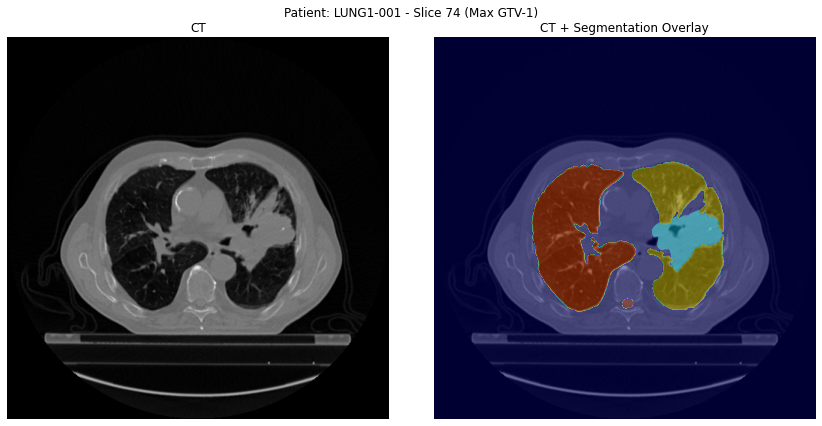

In [10]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

# Parent folder
parent_folder = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI'

# List all patient folders
patient_folders = sorted(glob(os.path.join(parent_folder, '*')))

for patient_folder in patient_folders[0:1]:
    # Find the CT file: should match NSCLC_XXX_0000.nii.gz
    ct_files = glob(os.path.join(patient_folder, 'NSCLC_*_0000.nii.gz'))
    if len(ct_files) == 0:
        print(f"No CT file found in {patient_folder}")
        continue
    
    ct_path = ct_files[0]
    seg_path = os.path.join(patient_folder, 'segmentation.nii.gz')
    
    if not os.path.exists(seg_path):
        print(f"No segmentation file in {patient_folder}")
        continue
    
    # Load images
    ct_image = sitk.ReadImage(ct_path)
    seg_image = sitk.ReadImage(seg_path)
    
    ct_array = sitk.GetArrayFromImage(ct_image)
    seg_array = sitk.GetArrayFromImage(seg_image)
    
    # Find slice index with max number of label 2 (GTV-1)
    label_2_counts = np.sum(seg_array == 2, axis=(1, 2))  # sum over height and width
    if np.max(label_2_counts) == 0:
        print(f"No label-2 (GTV-1) found in {patient_folder}")
        continue
    
    slice_idx = np.argmax(label_2_counts)
    ct_slice = ct_array[slice_idx, :, :]
    seg_slice = seg_array[slice_idx, :, :]
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Patient: {os.path.basename(patient_folder)} - Slice {slice_idx} (Max GTV-1)")
    
    plt.subplot(1, 2, 1)
    plt.imshow(ct_slice, cmap='gray')
    plt.title('CT')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(ct_slice, cmap='gray')
    plt.imshow(seg_slice, cmap='jet', alpha=0.4)
    plt.title('CT + Segmentation Overlay')
    plt.axis('off')
    plt.tight_layout()
    
    plt.show()


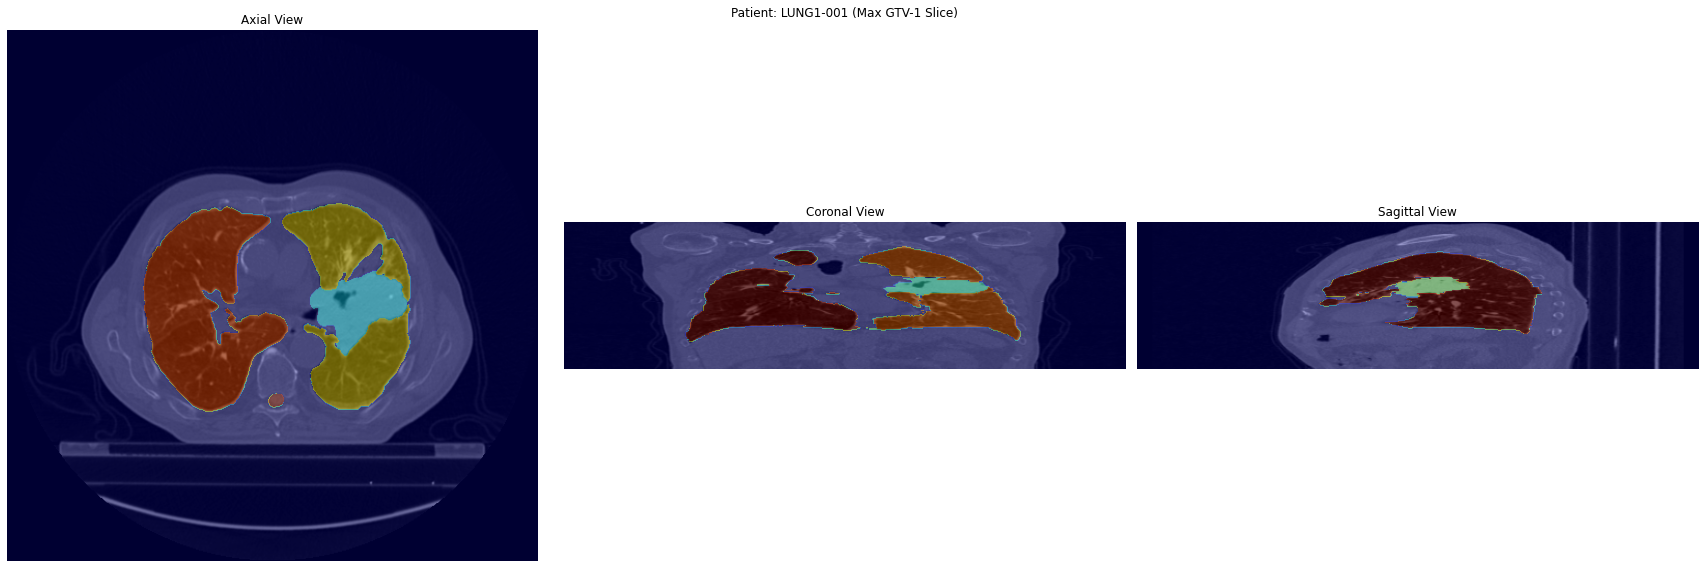

In [9]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

def plot_single_row(ct_np, seg_np, z, y, x, patient_name):
    # Axial (Z slice)
    axial_ct = ct_np[z, :, :]
    axial_seg = seg_np[z, :, :]

    # Coronal (Y slice)
    coronal_ct = ct_np[:, y, :]
    coronal_seg = seg_np[:, y, :]

    # Sagittal (X slice)
    sagittal_ct = ct_np[:, :, x]
    sagittal_seg = seg_np[:, :, x]

    planes = ['Axial', 'Coronal', 'Sagittal']
    data = [(axial_ct, axial_seg), (coronal_ct, coronal_seg), (sagittal_ct, sagittal_seg)]

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle(f"Patient: {patient_name} (Max GTV-1 Slice)")

    for i, (ct_img, seg_img) in enumerate(data):
        if i==0:
            axes[i].imshow(ct_img, cmap='gray')
            axes[i].imshow(seg_img, cmap='jet', alpha=0.4)
        else:
            axes[i].imshow(ct_img, cmap='gray',origin='lower')
            axes[i].imshow(seg_img, cmap='jet', alpha=0.4,origin='lower')
        axes[i].set_title(f'{planes[i]} View')
        axes[i].axis('off')
        

    plt.tight_layout()
    plt.show()


# Parent folder
parent_folder = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI'

# List all patient folders
patient_folders = sorted(glob(os.path.join(parent_folder, '*')))

for patient_folder in patient_folders[0:1]:
    ct_files = glob(os.path.join(patient_folder, 'NSCLC_*_0000.nii.gz'))
    if len(ct_files) == 0:
        print(f"No CT file found in {patient_folder}")
        continue

    ct_path = ct_files[0]
    seg_path = os.path.join(patient_folder, 'segmentation.nii.gz')

    if not os.path.exists(seg_path):
        print(f"No segmentation file in {patient_folder}")
        continue

    # Load images
    ct_image = sitk.ReadImage(ct_path)
    seg_image = sitk.ReadImage(seg_path)

    ct_array = sitk.GetArrayFromImage(ct_image)
    seg_array = sitk.GetArrayFromImage(seg_image)

    # Find slice index with max number of label 2 (GTV-1)
    label_2_counts = np.sum(seg_array == 2, axis=(1, 2))
    if np.max(label_2_counts) == 0:
        print(f"No label-2 (GTV-1) found in {patient_folder}")
        continue

    z_idx = np.argmax(label_2_counts)

    # For coronal and sagittal, center on the labeled region
    y_indices, x_indices = np.where(seg_array[z_idx, :, :] == 2)
    if len(y_indices) == 0 or len(x_indices) == 0:
        y_idx = seg_array.shape[1] // 2
        x_idx = seg_array.shape[2] // 2
    else:
        y_idx = int(np.median(y_indices))
        x_idx = int(np.median(x_indices))

    patient_name = os.path.basename(patient_folder)
    plot_single_row(ct_array, seg_array, z_idx, y_idx, x_idx, patient_name)


# Bouding Box-- CombinedSeg

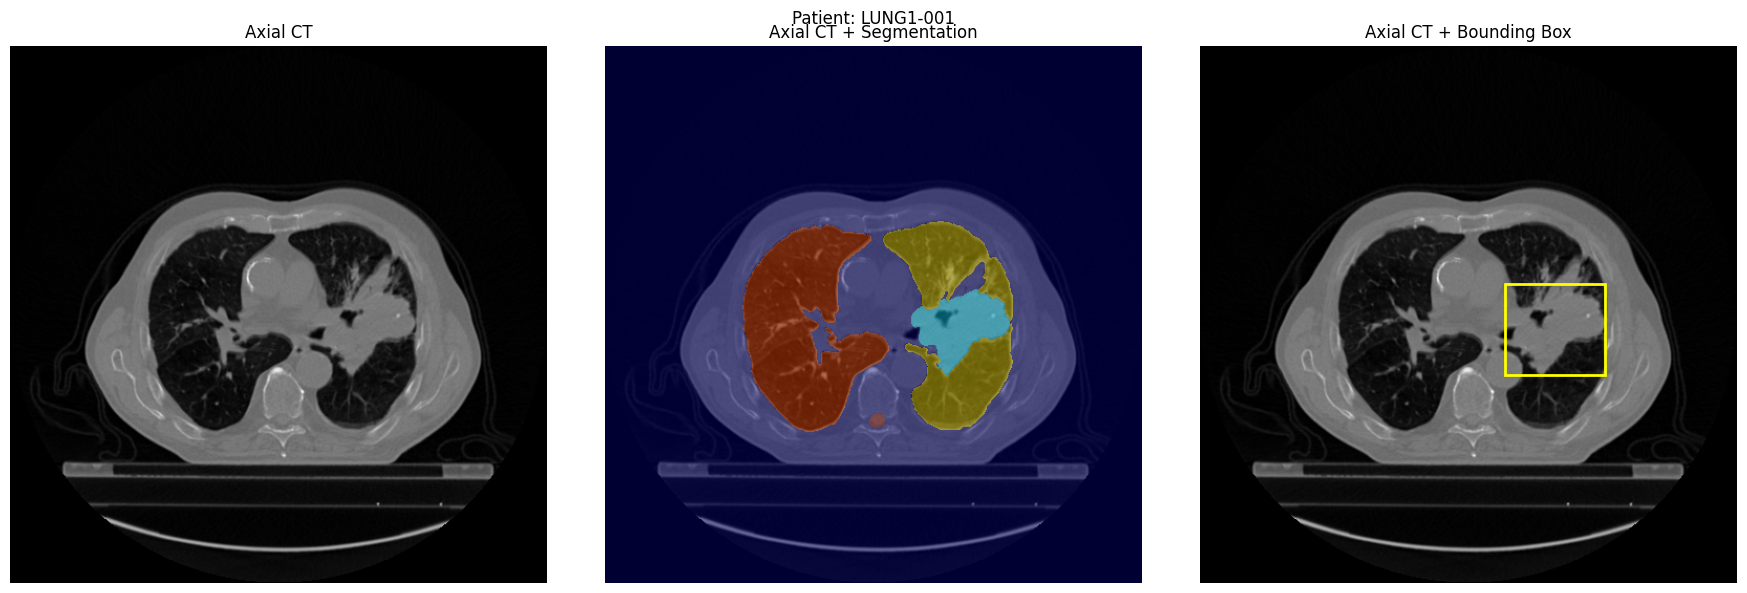

In [3]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Prepare CSV storage
bounding_boxes = []

# Parent folder
parent_folder = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI'
patient_folders = sorted(glob(os.path.join(parent_folder, '*')))

for patient_folder in patient_folders[0:1]:
    ct_files = glob(os.path.join(patient_folder, 'NSCLC_*_0000.nii.gz'))
    if len(ct_files) == 0:
        print(f"No CT file found in {patient_folder}")
        continue

    ct_path = ct_files[0]
    seg_path = os.path.join(patient_folder, 'segmentation.nii.gz')

    if not os.path.exists(seg_path):
        print(f"No segmentation file in {patient_folder}")
        continue

    # Load images
    ct_image  = sitk.ReadImage(ct_path)
    seg_image = sitk.ReadImage(seg_path)
    ct_array  = sitk.GetArrayFromImage(ct_image)
    seg_array = sitk.GetArrayFromImage(seg_image)

    spacing = np.array(seg_image.GetSpacing())  # (x, y, z)
    origin = np.array(seg_image.GetOrigin())
    direction = np.array(seg_image.GetDirection()).reshape(3, 3)

    # Find voxels with label 2
    indices = np.argwhere(seg_array == 2)  # (z, y, x)
    if indices.size == 0:
        print(f"No label-2 (GTV-1) found in {patient_folder}")
        continue

    min_z, min_y, min_x = indices.min(axis=0)
    max_z, max_y, max_x = indices.max(axis=0)

    center_voxel = np.array([(min_x + max_x) / 2, (min_y + max_y) / 2, (min_z + max_z) / 2])
    size_voxel = np.array([max_x - min_x + 1, max_y - min_y + 1, max_z - min_z + 1])

    center_world = origin + direction @ (center_voxel * spacing)
    size_mm = size_voxel * spacing[[0, 1, 2]]

    patient_name = os.path.basename(patient_folder)

    # Prepare axial slice
    z_idx = int(center_voxel[2])
    axial_ct = ct_array[z_idx, :, :]
    axial_seg = seg_array[z_idx, :, :]

    # Plot 1-row 3-column
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Patient: {patient_name}")

    # 1️⃣ CT only
    axes[0].imshow(axial_ct, cmap='gray')
    axes[0].set_title('Axial CT')
    axes[0].axis('off')

    # 2️⃣ CT + segmentation overlay
    axes[1].imshow(axial_ct, cmap='gray')
    axes[1].imshow(axial_seg, cmap='jet', alpha=0.4)
    axes[1].set_title('Axial CT + Segmentation')
    axes[1].axis('off')

    # 3️⃣ CT + bounding box
    axes[2].imshow(axial_ct, cmap='gray')
    rect_x = min_x
    rect_y = min_y
    rect_w = max_x - min_x
    rect_h = max_y - min_y
    axes[2].add_patch(plt.Rectangle((rect_x, rect_y), rect_w, rect_h,
                                    edgecolor='yellow', facecolor='none', linewidth=2))
    axes[2].set_title('Axial CT + Bounding Box')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Getting Bounding box in World Coordinate

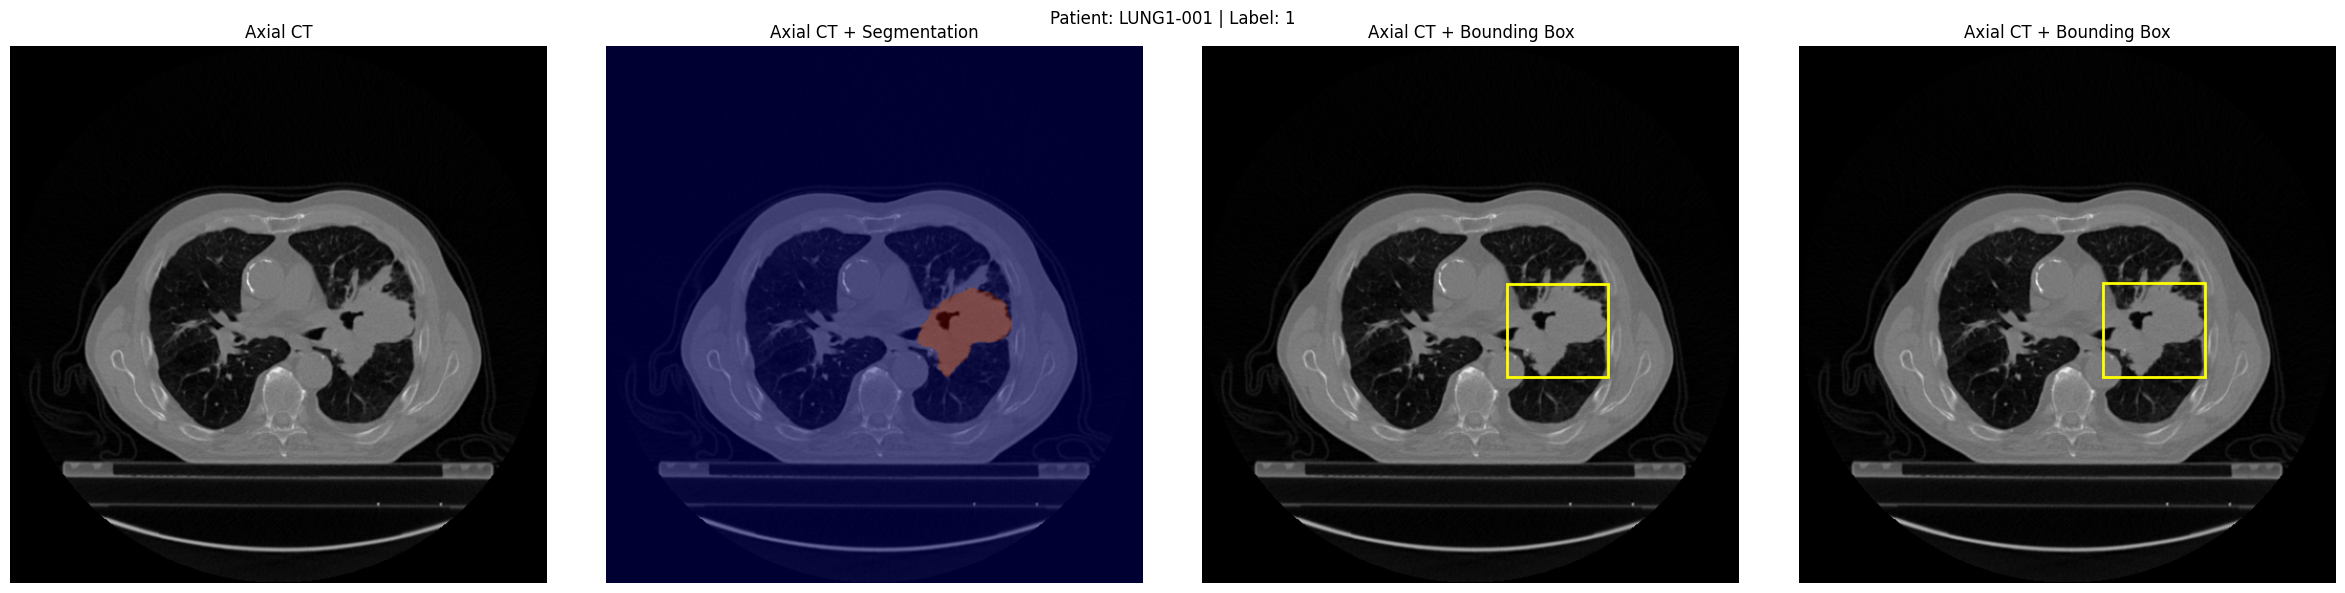

Saved bounding box CSV to: NSCLC_bounding_boxes_annotations.csv


In [9]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Prepare CSV storage
bounding_boxes = []

# Parent folder
parent_folder = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI'
patient_folders = sorted(glob(os.path.join(parent_folder, '*')))

for patient_folder in patient_folders[0:1]:
    ct_files = glob(os.path.join(patient_folder, 'NSCLC_*_0000.nii.gz'))
    if len(ct_files) == 0:
        print(f"No CT file found in {patient_folder}")
        continue

    ct_path = ct_files[0]
    seg_path = os.path.join(patient_folder, 'seg-GTV-1.nii.gz')

    if not os.path.exists(seg_path):
        print(f"No segmentation file in {patient_folder}")
        continue

    # Load images
    ct_image  = sitk.ReadImage(ct_path)
    seg_image = sitk.ReadImage(seg_path)
    ct_array  = sitk.GetArrayFromImage(ct_image)
    seg_array = sitk.GetArrayFromImage(seg_image)

    spacing = np.array(seg_image.GetSpacing())  # (x, y, z)
    origin = np.array(seg_image.GetOrigin())
    direction = np.array(seg_image.GetDirection()).reshape(3, 3)

    # 🔴 NEW: Handle multiple labels inside segmentation
    unique_labels = np.unique(seg_array)
    unique_labels = unique_labels[unique_labels != 0]  # skip background

    for label in unique_labels:
        indices = np.argwhere(seg_array == label)
        if indices.size == 0:
            print(f"No label-{label} found in {patient_folder}")
            continue

        min_z, min_y, min_x = indices.min(axis=0)
        max_z, max_y, max_x = indices.max(axis=0)

        center_voxel = np.asarray([int((min_x + max_x) / 2), int((min_y + max_y) / 2), int((min_z + max_z) / 2)])
        size_voxel   = np.array([max_x - min_x + 1, max_y - min_y + 1, max_z - min_z + 1])

        center_world = ct_image.TransformIndexToPhysicalPoint(center_voxel.tolist())
        size_mm      = size_voxel * spacing[[0, 1, 2]]
        
        center_voxel2 = ct_image.TransformPhysicalPointToIndex(center_world)
        size          = size_mm // spacing[[0, 1, 2]]

        patient_name = os.path.basename(patient_folder)
        bounding_boxes.append({
            'Patient': patient_name,
            'ct_path': os.path.join(*ct_path.split('/')[-2:]),
            'seg_path':os.path.join(*seg_path.split('/')[-2:]),
            'Label': int(label),  # 🔴 NEW: store label
            'coordX': center_world[0],
            'coordY': center_world[1],
            'coordZ': center_world[2],
            'w'     : size_mm[0],
            'h'     : size_mm[1],
            'd'     : size_mm[2],
        })

        # Prepare axial slice
        z_idx     = int(center_voxel[2])
        axial_ct  = ct_array[z_idx, :, :]
        axial_seg = (seg_array[z_idx, :, :] == label).astype(int)  # only this label
        
        axial_ct2 = ct_array[center_voxel2[2], :, :]

        # Plot 1-row 3-column
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        fig.suptitle(f"Patient: {patient_name} | Label: {label}")

        # 1️⃣ CT only
        axes[0].imshow(axial_ct, cmap='gray')
        axes[0].set_title('Axial CT')
        axes[0].axis('off')

        # 2️⃣ CT + segmentation overlay
        axes[1].imshow(axial_ct, cmap='gray')
        axes[1].imshow(axial_seg, cmap='jet', alpha=0.4)
        axes[1].set_title('Axial CT + Segmentation')
        axes[1].axis('off')

        # 3️⃣ CT + bounding box
        axes[2].imshow(axial_ct, cmap='gray')
        rect_x = min_x
        rect_y = min_y
        rect_w = max_x - min_x
        rect_h = max_y - min_y
        axes[2].add_patch(plt.Rectangle((rect_x, rect_y), rect_w, rect_h, edgecolor='yellow', facecolor='none', linewidth=2))
        axes[2].set_title('Axial CT + Bounding Box')
        axes[2].axis('off')

        axes[3].imshow(axial_ct, cmap='gray')
        rect_x = int(center_voxel2[0] - size[0] // 2)
        rect_y = int(center_voxel2[1] - size[1] // 2)
        rect_w = size[0]
        rect_h = size[1]
        axes[3].add_patch(plt.Rectangle((rect_x, rect_y), rect_w, rect_h, edgecolor='yellow', facecolor='none', linewidth=2))
        axes[3].set_title('Axial CT + Bounding Box')
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

# Save bounding boxes to CSV
df = pd.DataFrame(bounding_boxes)
output_csv = 'NSCLC_bounding_boxes_annotations.csv'
#df.to_csv(output_csv, index=False)
print(f"Saved bounding box CSV to: {output_csv}")


# Annotation_Checking

|------------------------------ No=1 ------------------------------|


Loading the Image:LUNG1-001
Number of Annotations:1
Histology...|large cell


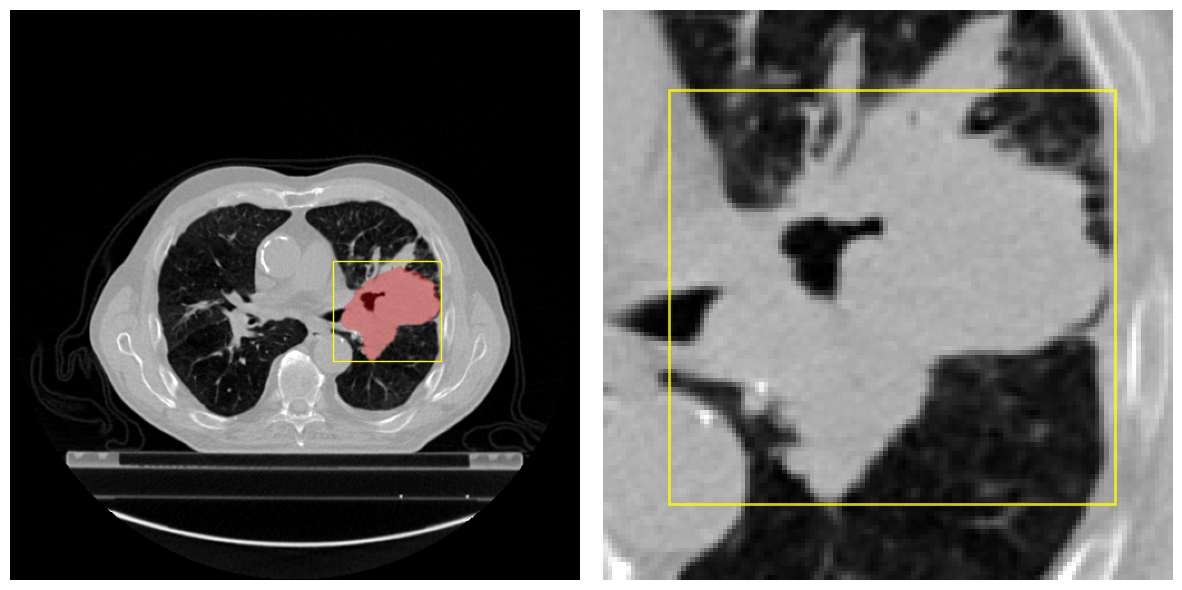

In [6]:
#-| Import libraries
#import cv2
import numpy as np
import SimpleITK as sitk
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import math 
import pandas as pd
import numpy.ma as ma

##################################---Functions-------------#######################

def make_bold(text):
    return f"\033[1m{text}\033[0m"

#-| this function load an image using simpleITK and return 
#-|3D array, origin_numpy and spacing numpy
def load_itk_image(filename):
    '''
    this function load an image using simpleITK and return
    3D array, origin_numpy and spacing numpy
    input:  filename     = nifty CT image path eg."./CT_CTGRAV_TMP404180_4.nii.gz"
    output: numpyImage   = 3D CT numpy as slice X height x Width (z,y,x)
            numpyOrigin  = (z_origin,  y_origin,  x_origin)
            numpySpacing = (z_Spacing, y_Spacing, x_Spacing)
    '''
    itkimage = sitk.ReadImage(filename)           # load the ct image
    numpyImage = sitk.GetArrayFromImage(itkimage) # give CT to 3D numpy (z,y,x)
   
    #- When we load get the  itkimage.GetOrigin/GetSpacing it 
    # returns the array in order (x_origin, y_origin,z_origin)
    # as we loaded the CT image as 3D numpy (z,y,x) that is why
    # we also reversed the acquired spacing and origin
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))   # 3D numpy (z_origin,  y_origin,  x_origin)
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing()))) # 3D numpy (z_Spacing, y_Spacing, x_Spacing)
    return numpyImage, numpyOrigin, numpySpacing

#-| this function will convert the world coordinate to the voxel coordinate
 #-|to visualize or acquired the bounding boxex on the 3D CT 
def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def normalize_image_to_uint8(image, lower_bound=-1000, upper_bound=500.0):
    """
    Clip the image to the lung window, then normalize it to uint8.
    Args:
        image: numpy array
        lower_bound: lower HU bound for the lung window (default: -1500 HU)
        upper_bound: upper HU bound for the lung window (default: -500 HU)
    """
    # Clip to lung window
    clipped_img = np.clip(image, lower_bound, upper_bound)
    
    # Normalize to [0, 255]
    normalized_img = ((clipped_img - lower_bound) / (upper_bound - lower_bound)) * 255.0
    normalized_img = normalized_img.astype(np.uint8)
    
    return normalized_img

def is_number_in_range(number, start, end):
    """
    Check if the number is within the range [start, end] (inclusive).
    
    Args:
    number (int/float): The number to check.
    start (int/float): The start of the range.
    end (int/float): The end of the range.
    
    Returns:
    bool: True if the number is within the range, False otherwise.
    """
    return start <= number <= end

#--------------- Reading CSV files--------------#
# Load the first CSV file
segValue      = 1
NSCLC_metadata = pd.read_csv('NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv')
predM          = pd.read_csv('NSCLC_bounding_boxes_annotations.csv')
predM          = predM.merge(NSCLC_metadata,left_on='Patient',right_on='PatientID',how='left')

raw_data_path = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/'

# Get unique seriesuid values from the first CSV file
Final_dect = predM['Patient'].unique()

for dictonary_list_i in range(0, 1):#len(Final_dect)):
    print(make_bold('|' + '-'*30 + ' No={} '.format(dictonary_list_i+1) + '-'*30 + '|'))
    print('\n')
    
    desired_value      = Final_dect[dictonary_list_i]  # Get the seriesuid
    filtered_dpredM    = predM[predM['Patient'] == desired_value]
    example_dictionary = filtered_dpredM.reset_index()


    # Load the CT image
    print('Loading the Image:{}'.format(example_dictionary['Patient'][0]))
    print('Number of Annotations:{}'.format(len(example_dictionary)))
    
    ct_path   = raw_data_path + '/' + example_dictionary['ct_path'][0]  
    ct_image  = sitk.ReadImage(ct_path)
    ct_array  = sitk.GetArrayFromImage(ct_image)
    spacing   = np.array(ct_image.GetSpacing()) # (x, y, z)
    origin    = np.array(ct_image.GetOrigin())
    direction = np.array(ct_image.GetDirection()).reshape(3, 3)
    
    seg_path  = raw_data_path + '/' + example_dictionary['seg_path'][0]
    seg_image = sitk.ReadImage(seg_path)
    seg_array = sitk.GetArrayFromImage(seg_image)

    for Which_box_to_use in range(0, len(example_dictionary)):
        
        #---------GT---Part
        worldCoord_gt = np.asarray([float(example_dictionary["coordX"][Which_box_to_use]), float(example_dictionary["coordY"][Which_box_to_use]), float(example_dictionary["coordZ"][Which_box_to_use])])
        voxelCoord_gt = ct_image.TransformPhysicalPointToIndex(worldCoord_gt)
        
        size_mm       = np.asarray([float(example_dictionary["w"][Which_box_to_use]), float(example_dictionary["h"][Which_box_to_use]), float(example_dictionary["d"][Which_box_to_use])])
        size          = size_mm // spacing[[0, 1, 2]]
        
        
        value = example_dictionary["Histology"][Which_box_to_use]

        cleaned_value = (
            'Histology' if isinstance(value, str) and value == 'Histology'
            else 'missing' if pd.isna(value) or (isinstance(value, float) and np.isnan(value))
            else value
        )
        print('Histology...|{}'.format(cleaned_value))
        
        
        
        #--- Getting the bounding box start and end of the X (width)
        gtstart_x = int(voxelCoord_gt[0] - (size[0]//2))
        gtend_x   = int(voxelCoord_gt[0] + (size[0]//2))

        #--- Getting the bounding box start and end of the y
        gtstart_y = int(voxelCoord_gt[1] - (size[1]//2))
        gtend_y   = int(voxelCoord_gt[1] + (size[1]//2))

        #--- Getting the bounding box start and end of the z
        gtstart_z = int(voxelCoord_gt[2] - (size[2]//2))
        gtend_z   = int(voxelCoord_gt[2] + (size[2]//2))

        gtdraw_box_z = int(voxelCoord_gt[2])  # the z-slice we will visualize
        
        axial_seg    = (seg_array[gtdraw_box_z, :, :] == segValue).astype(int)    # only this label
        masked_seg   = ma.masked_where(axial_seg == 0, axial_seg)
        draw_img     = normalize_image_to_uint8(ct_array[gtdraw_box_z, :, :])
        #draw_img     = cv2.cvtColor(draw_img, cv2.COLOR_GRAY2BGR)

        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Plot the full CT slice in the first subplot
        ax1.imshow(draw_img,  cmap='gray')
        ax1.imshow(masked_seg, cmap='autumn', alpha=0.3)
        
        ax1.add_patch(plt.Rectangle((gtstart_x, gtstart_y), 
                                    int(size[0]), 
                                    int(size[1]), fill=False, edgecolor='yellow', linewidth=1, alpha=1))
        #ax1.set_title('Full CT Slice')
        ax1.axis('off')

        # Extract a 32x32x32 cube around the bounding box
        cube_size = 124
        
        z_start = max(0, int(voxelCoord_gt[2]) - cube_size // 2)
        z_end   = min(ct_array.shape[0], z_start + cube_size)
        
        y_start = max(0, int(voxelCoord_gt[1]) - cube_size // 2)
        y_end   = min(ct_array.shape[1], y_start + cube_size)
        
        x_start = max(0, int(voxelCoord_gt[0]) - cube_size // 2)
        x_end   = min(ct_array.shape[2], x_start + cube_size)

        # Ensure the cube is 32x32x32 by padding if necessary
        cube = ct_array[z_start:z_end, y_start:y_end, x_start:x_end]
        if cube.shape != (cube_size, cube_size, cube_size):
            pad_z = max(0, cube_size - cube.shape[0])
            pad_y = max(0, cube_size - cube.shape[1])
            pad_x = max(0, cube_size - cube.shape[2])
            cube = np.pad(cube, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant')

        # Display the middle slice of the cube in the second subplot
        middle_slice = cube[cube_size // 2, :, :]
        middle_slice = normalize_image_to_uint8(middle_slice)
        ax2.imshow(middle_slice, cmap='gray')
        #ax2.set_title('32x32x32 Cube (Middle Slice)')
        ax2.axis('off')

        # Adjust bounding box coordinates for the zoomed-in region
        adjusted_gtstart_x = gtstart_x - x_start
        adjusted_gtstart_y = gtstart_y - y_start
        

        # Draw bounding box on the zoomed-in image
        ax2.add_patch(plt.Rectangle((adjusted_gtstart_x, adjusted_gtstart_y), int(size[0]),int(size[1]), fill=False, edgecolor='yellow', linewidth=2, alpha=0.8))

        
        plt.tight_layout()        
        plt.show()

# Resampling

In [1]:
import os
import argparse
import numpy as np
import SimpleITK as sitk
import pandas as pd

def resample_img(itk_image, out_spacing, is_label=False):
    # Resample images to the specified spacing
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))
    ]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)





segValue      = 1
NSCLC_metadata = pd.read_csv('NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv')
predM          = pd.read_csv('NSCLC_bounding_boxes_annotations.csv')
predM          = predM.merge(NSCLC_metadata,left_on='Patient',right_on='PatientID',how='left')

raw_data_path = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/'
output_folder = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/'
new_spacing   = [0.703125, 0.703125, 1.25]
is_label      = False 
extension     =".nii.gz"

# Get unique seriesuid values from the first CSV file
Final_dect = predM['Patient'].unique()

for dictonary_list_i in range(0, len(Final_dect)):
    
    desired_value      = Final_dect[dictonary_list_i]  # Get the seriesuid
    filtered_dpredM    = predM[predM['Patient'] == desired_value]
    example_dictionary = filtered_dpredM.reset_index()

    ct_path    = raw_data_path + '/' + example_dictionary['ct_path'][0] 
    image      = sitk.ReadImage(ct_path)

    # Resample the image
    resampled_image = resample_img(image, new_spacing, is_label)

    # Construct the output filename (keep the same name)
    filename    = example_dictionary['ct_path'][0].split('/')[-1]
    output_path = os.path.join(output_folder, filename)

    # Save the resampled image
    sitk.WriteImage(resampled_image, output_path)
    print(f"Saved resampled image to {output_path}")




Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_001_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_002_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_003_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_004_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_005_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_006_0000

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_050_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_051_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_052_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_053_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_054_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_055_0000

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_099_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_100_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_101_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_102_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_103_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_104_0000

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_149_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_150_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_151_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_152_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_153_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_154_0000

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_198_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_199_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_200_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_201_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_202_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_203_0000

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_247_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_248_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_249_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_250_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_251_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_252_0000

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_296_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_297_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_298_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_299_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_300_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_301_0000

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_345_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_346_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_347_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_348_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_349_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_350_0000

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_394_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_395_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_396_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_397_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_398_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/NSCLC_399_0000

# Checking if the Resampling is Aligned with Annotations

|------------------------------ No=1 ------------------------------|


Loading the Image:LUNG1-001
Number of Annotations:1
Histology...|large cell


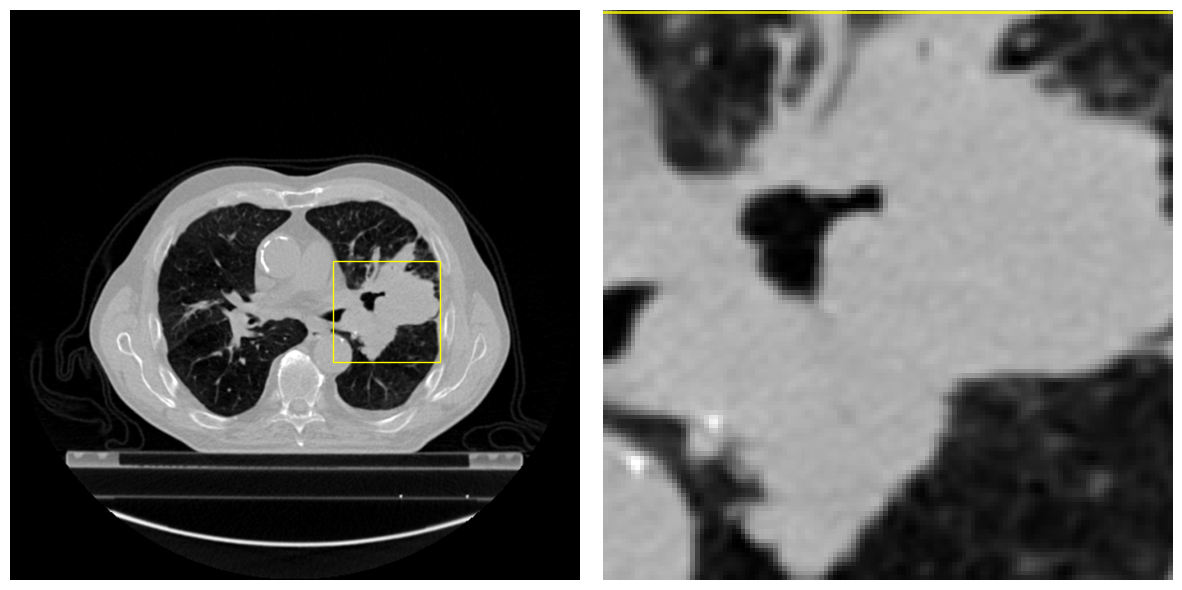

In [8]:
#-| Import libraries
#import cv2
import numpy as np
import SimpleITK as sitk
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import math 
import pandas as pd
import numpy.ma as ma

##################################---Functions-------------#######################

def make_bold(text):
    return f"\033[1m{text}\033[0m"

#-| this function load an image using simpleITK and return 
#-|3D array, origin_numpy and spacing numpy
def load_itk_image(filename):
    '''
    this function load an image using simpleITK and return
    3D array, origin_numpy and spacing numpy
    input:  filename     = nifty CT image path eg."./CT_CTGRAV_TMP404180_4.nii.gz"
    output: numpyImage   = 3D CT numpy as slice X height x Width (z,y,x)
            numpyOrigin  = (z_origin,  y_origin,  x_origin)
            numpySpacing = (z_Spacing, y_Spacing, x_Spacing)
    '''
    itkimage = sitk.ReadImage(filename)           # load the ct image
    numpyImage = sitk.GetArrayFromImage(itkimage) # give CT to 3D numpy (z,y,x)
   
    #- When we load get the  itkimage.GetOrigin/GetSpacing it 
    # returns the array in order (x_origin, y_origin,z_origin)
    # as we loaded the CT image as 3D numpy (z,y,x) that is why
    # we also reversed the acquired spacing and origin
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))   # 3D numpy (z_origin,  y_origin,  x_origin)
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing()))) # 3D numpy (z_Spacing, y_Spacing, x_Spacing)
    return numpyImage, numpyOrigin, numpySpacing

#-| this function will convert the world coordinate to the voxel coordinate
 #-|to visualize or acquired the bounding boxex on the 3D CT 
def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def normalize_image_to_uint8(image, lower_bound=-1000, upper_bound=500.0):
    """
    Clip the image to the lung window, then normalize it to uint8.
    Args:
        image: numpy array
        lower_bound: lower HU bound for the lung window (default: -1500 HU)
        upper_bound: upper HU bound for the lung window (default: -500 HU)
    """
    # Clip to lung window
    clipped_img = np.clip(image, lower_bound, upper_bound)
    
    # Normalize to [0, 255]
    normalized_img = ((clipped_img - lower_bound) / (upper_bound - lower_bound)) * 255.0
    normalized_img = normalized_img.astype(np.uint8)
    
    return normalized_img

def is_number_in_range(number, start, end):
    """
    Check if the number is within the range [start, end] (inclusive).
    
    Args:
    number (int/float): The number to check.
    start (int/float): The start of the range.
    end (int/float): The end of the range.
    
    Returns:
    bool: True if the number is within the range, False otherwise.
    """
    return start <= number <= end

#--------------- Reading CSV files--------------#
# Load the first CSV file
segValue      = 1
NSCLC_metadata = pd.read_csv('NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv')
predM          = pd.read_csv('NSCLC_bounding_boxes_annotations.csv')
predM          = predM.merge(NSCLC_metadata,left_on='Patient',right_on='PatientID',how='left')

raw_data_path = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/'
output_folder = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/'

# Get unique seriesuid values from the first CSV file
Final_dect = predM['Patient'].unique()

for dictonary_list_i in range(0, 1):#len(Final_dect)):
    print(make_bold('|' + '-'*30 + ' No={} '.format(dictonary_list_i+1) + '-'*30 + '|'))
    print('\n')
    
    desired_value      = Final_dect[dictonary_list_i]  # Get the seriesuid
    filtered_dpredM    = predM[predM['Patient'] == desired_value]
    example_dictionary = filtered_dpredM.reset_index()


    # Load the CT image
    print('Loading the Image:{}'.format(example_dictionary['Patient'][0]))
    print('Number of Annotations:{}'.format(len(example_dictionary)))
    
    

    filename    = example_dictionary['ct_path'][0].split('/')[-1]
    ct_path     = os.path.join(raw_data_path, filename)
     
    ct_image  = sitk.ReadImage(ct_path)
    ct_array  = sitk.GetArrayFromImage(ct_image)
    spacing   = np.array(ct_image.GetSpacing()) # (x, y, z)
    origin    = np.array(ct_image.GetOrigin())
    direction = np.array(ct_image.GetDirection()).reshape(3, 3)
    
    for Which_box_to_use in range(0, 1):#len(example_dictionary)):
        
        #---------GT---Part
        worldCoord_gt = np.asarray([float(example_dictionary["coordX"][Which_box_to_use]), float(example_dictionary["coordY"][Which_box_to_use]), float(example_dictionary["coordZ"][Which_box_to_use])])
        voxelCoord_gt = ct_image.TransformPhysicalPointToIndex(worldCoord_gt)
        
        size_mm       = np.asarray([float(example_dictionary["w"][Which_box_to_use]), float(example_dictionary["h"][Which_box_to_use]), float(example_dictionary["d"][Which_box_to_use])])
        size          = size_mm // spacing[[0, 1, 2]]
        
        
        value = example_dictionary["Histology"][Which_box_to_use]

        cleaned_value = (
            'Histology' if isinstance(value, str) and value == 'Histology'
            else 'missing' if pd.isna(value) or (isinstance(value, float) and np.isnan(value))
            else value
        )
        print('Histology...|{}'.format(cleaned_value))
        
        
        
        #--- Getting the bounding box start and end of the X (width)
        gtstart_x = int(voxelCoord_gt[0] - (size[0]//2))
        gtend_x   = int(voxelCoord_gt[0] + (size[0]//2))

        #--- Getting the bounding box start and end of the y
        gtstart_y = int(voxelCoord_gt[1] - (size[1]//2))
        gtend_y   = int(voxelCoord_gt[1] + (size[1]//2))

        #--- Getting the bounding box start and end of the z
        gtstart_z = int(voxelCoord_gt[2] - (size[2]//2))
        gtend_z   = int(voxelCoord_gt[2] + (size[2]//2))

        gtdraw_box_z = int(voxelCoord_gt[2])  # the z-slice we will visualize
        draw_img     = normalize_image_to_uint8(ct_array[gtdraw_box_z, :, :])
        #draw_img     = cv2.cvtColor(draw_img, cv2.COLOR_GRAY2BGR)

        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Plot the full CT slice in the first subplot
        ax1.imshow(draw_img,  cmap='gray')
        
        ax1.add_patch(plt.Rectangle((gtstart_x, gtstart_y), 
                                    int(size[0]), 
                                    int(size[1]), fill=False, edgecolor='yellow', linewidth=1, alpha=1))
        #ax1.set_title('Full CT Slice')
        ax1.axis('off')

        # Extract a 32x32x32 cube around the bounding box
        cube_size = 124
        
        z_start = max(0, int(voxelCoord_gt[2]) - cube_size // 2)
        z_end   = min(ct_array.shape[0], z_start + cube_size)
        
        y_start = max(0, int(voxelCoord_gt[1]) - cube_size // 2)
        y_end   = min(ct_array.shape[1], y_start + cube_size)
        
        x_start = max(0, int(voxelCoord_gt[0]) - cube_size // 2)
        x_end   = min(ct_array.shape[2], x_start + cube_size)

        # Ensure the cube is 32x32x32 by padding if necessary
        cube = ct_array[z_start:z_end, y_start:y_end, x_start:x_end]
        if cube.shape != (cube_size, cube_size, cube_size):
            pad_z = max(0, cube_size - cube.shape[0])
            pad_y = max(0, cube_size - cube.shape[1])
            pad_x = max(0, cube_size - cube.shape[2])
            cube = np.pad(cube, ((0, pad_z), (0, pad_y), (0, pad_x)), mode='constant')

        # Display the middle slice of the cube in the second subplot
        middle_slice = cube[cube_size // 2, :, :]
        middle_slice = normalize_image_to_uint8(middle_slice)
        ax2.imshow(middle_slice, cmap='gray')
        #ax2.set_title('32x32x32 Cube (Middle Slice)')
        ax2.axis('off')

        # Adjust bounding box coordinates for the zoomed-in region
        adjusted_gtstart_x = gtstart_x - x_start
        adjusted_gtstart_y = gtstart_y - y_start
        

        # Draw bounding box on the zoomed-in image
        ax2.add_patch(plt.Rectangle((adjusted_gtstart_x, adjusted_gtstart_y), int(size[0]),int(size[1]), fill=False, edgecolor='yellow', linewidth=2, alpha=0.8))

        
        plt.tight_layout()        
        plt.show()

# Resample_Segmentation_mask

In [ ]:
seg_path  = raw_data_path + '/' + example_dictionary['seg_path'][0]


import os
import argparse
import numpy as np
import SimpleITK as sitk
import pandas as pd

def resample_img(itk_image, out_spacing, is_label=False):
    # Resample images to the specified spacing
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))
    ]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)





segValue       = 1
NSCLC_metadata = pd.read_csv('NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv')
predM          = pd.read_csv('NSCLC_bounding_boxes_annotations.csv')
predM          = predM.merge(NSCLC_metadata,left_on='Patient',right_on='PatientID',how='left')

raw_data_path = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC-Radiomics-NIFTI/'
output_folder = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/'
new_spacing   = [0.703125, 0.703125, 1.25]
is_label      = False 
extension     =".nii.gz"

# Get unique seriesuid values from the first CSV file
Final_dect = predM['Patient'].unique()

for dictonary_list_i in range(0, len(Final_dect)):
    
    desired_value      = Final_dect[dictonary_list_i]  # Get the seriesuid
    filtered_dpredM    = predM[predM['Patient'] == desired_value]
    example_dictionary = filtered_dpredM.reset_index()

    ct_path    = raw_data_path + '/' + example_dictionary['seg_path'][0]
    image      = sitk.ReadImage(ct_path)

    # Resample the image
    resampled_image = resample_img(image, new_spacing, is_label=True)

    # Construct the output filename (keep the same name)
    filename    = example_dictionary['ct_path'][0].split('/')[-1]
    output_path = os.path.join(output_folder, filename)

    # Save the resampled image
    sitk.WriteImage(resampled_image, output_path)
    print(f"Saved resampled image to {output_path}")




Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_001_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_002_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_003_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_004_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_005_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_049_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_050_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_051_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_052_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_053_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_097_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_098_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_099_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_100_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_101_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_146_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_147_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_148_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_149_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_150_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_194_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_195_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_196_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_197_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_198_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_242_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_243_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_244_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_245_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_246_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_290_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_291_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_292_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_293_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_294_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_338_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_339_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_340_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_341_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_342_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI

Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_386_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_387_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_388_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_389_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_mask_resampled/NSCLC_390_0000.nii.gz
Saved resampled image to /NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI

# Dataset Demographics and Annotations

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# === Set random seed for reproducibility ===
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# === Step 1: Load CSVs ===
df_boxes = pd.read_csv("NSCLC_bounding_boxes_annotations.csv")
df_clinical = pd.read_csv("NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv")

# Normalize column names
df_boxes.columns = df_boxes.columns.str.lower()
df_clinical.columns = df_clinical.columns.str.lower()

# Merge on patient ID
df_merged = pd.merge(df_boxes, df_clinical, left_on="patient", right_on="patientid", how="inner")

# Fill missing histology with 'unknown'
df_merged["histology"] = df_merged["histology"].fillna("unknown")

# === Step 2: Stratified Split on Histology ===
train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for hist_type, group in df_merged.groupby("histology"):
    train, temp = train_test_split(group, test_size=0.2, random_state=SEED)
    val, test = train_test_split(temp, test_size=0.5, random_state=SEED)
    train["fitSplit"] = "train"
    val["fitSplit"] = "validation"
    test["fitSplit"] = "test"
    train_df = pd.concat([train_df, train])
    val_df = pd.concat([val_df, val])
    test_df = pd.concat([test_df, test])

# Combine back into full merged set
df_merged_split = pd.concat([train_df, val_df, test_df]).sort_index()

# === Step 3: Compute Summary Stats for Categorical Columns ===
def compute_split_stats_by_column(df_merged, train_df, val_df, test_df, column):
    total_count = df_merged[column].value_counts().rename("Total Count").to_frame()
    train_stats = train_df[column].value_counts().rename("Train Count").to_frame()
    val_stats = val_df[column].value_counts().rename("Val Count").to_frame()
    test_stats = test_df[column].value_counts().rename("Test Count").to_frame()

    all_stats = total_count.join([train_stats, val_stats, test_stats], how="outer").fillna(0)
    all_stats["Train (%)"] = (all_stats["Train Count"] / len(df_merged) * 100).round(1)
    all_stats["Val (%)"] = (all_stats["Val Count"] / len(df_merged) * 100).round(1)
    all_stats["Test (%)"] = (all_stats["Test Count"] / len(df_merged) * 100).round(1)

    all_stats = all_stats.astype({"Total Count": int, "Train Count": int, "Val Count": int, "Test Count": int})
    simplified = all_stats.assign(
        Train=lambda df: df["Train Count"].astype(str) + " (" + df["Train (%)"].astype(str) + "%)",
        Validation=lambda df: df["Val Count"].astype(str) + " (" + df["Val (%)"].astype(str) + "%)",
        Test=lambda df: df["Test Count"].astype(str) + " (" + df["Test (%)"].astype(str) + "%)",
        Total=all_stats["Total Count"]
    )[["Total", "Train", "Validation", "Test"]]

    simplified["Category"] = column
    return simplified.reset_index().rename(columns={"index": "Value"})

# === Step 4: Generate Tables for Clinical Variables ===
columns_to_analyze = ["gender", "overall.stage", "clinical.t.stage", "clinical.n.stage", "clinical.m.stage"]
all_tables = [compute_split_stats_by_column(df_merged, train_df, val_df, test_df, col) for col in columns_to_analyze]

# === Step 5: Age Summary (Mean ± Std and Max) ===
def age_summary(df):
    mean = df["age"].mean()
    std = df["age"].std()
    max_age = df["age"].max()
    return f"{mean:.1f} ± {std:.1f}", f"{max_age:.1f}"

age_train_mean_std, age_train_max = age_summary(train_df)
age_val_mean_std, age_val_max     = age_summary(val_df)
age_test_mean_std, age_test_max   = age_summary(test_df)
age_total_mean_std, age_total_max = age_summary(df_merged)

age_table = pd.DataFrame([
    {
        "Category": "Age",
        "Value": "Mean ± Std (years)",
        "Total": age_total_mean_std,
        "Train": age_train_mean_std,
        "Validation": age_val_mean_std,
        "Test": age_test_mean_std,
    },
    {
        "Category": "Age",
        "Value": "Max (years)",
        "Total": age_total_max,
        "Train": age_train_max,
        "Validation": age_val_max,
        "Test": age_test_max,
    }
])

# === Step 6: Combine Tables ===
clinical_summary_table = pd.concat([age_table] + all_tables, ignore_index=True)
clinical_summary_table = clinical_summary_table[["Category", "Value", "Total", "Train", "Validation", "Test"]]
clinical_summary_table = clinical_summary_table.sort_values(by=["Category", "Value"])

# === Step 7: Output Summary Table ===
print(tabulate(clinical_summary_table, headers="keys", tablefmt="grid", showindex=False))

# === Step 8: Save Merged and Split Files ===
df_merged_split.to_csv("NSCLCRadiomics_merged_with_fitSplit.csv", index=False)
train_df.to_csv("NSCLCRadiomics_train_split.csv", index=False)
val_df.to_csv("NSCLCRadiomics_validation_split.csv", index=False)
test_df.to_csv("NSCLCRadiomics_test_split.csv", index=False)
clinical_summary_table.to_csv("NSCLCRadiomics_clinical_summary_table.csv", index=False)


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


+------------------+--------------------+-------------+-------------+--------------+-------------+
| Category         | Value              | Total       | Train       | Validation   | Test        |
+==================+====================+=============+=============+==============+=============+
| Age              | Max (years)        | 91.7        | 88.4        | 91.7         | 88.3        |
+------------------+--------------------+-------------+-------------+--------------+-------------+
| Age              | Mean ± Std (years) | 68.0 ± 10.1 | 68.0 ± 9.9  | 68.7 ± 10.8  | 67.5 ± 11.0 |
+------------------+--------------------+-------------+-------------+--------------+-------------+
| clinical.m.stage | 0                  | 416         | 331 (78.6%) | 40 (9.5%)    | 45 (10.7%)  |
+------------------+--------------------+-------------+-------------+--------------+-------------+
| clinical.m.stage | 1                  | 1           | 0 (0.0%)    | 1 (0.2%)     | 0 (0.0%)    |
+---------

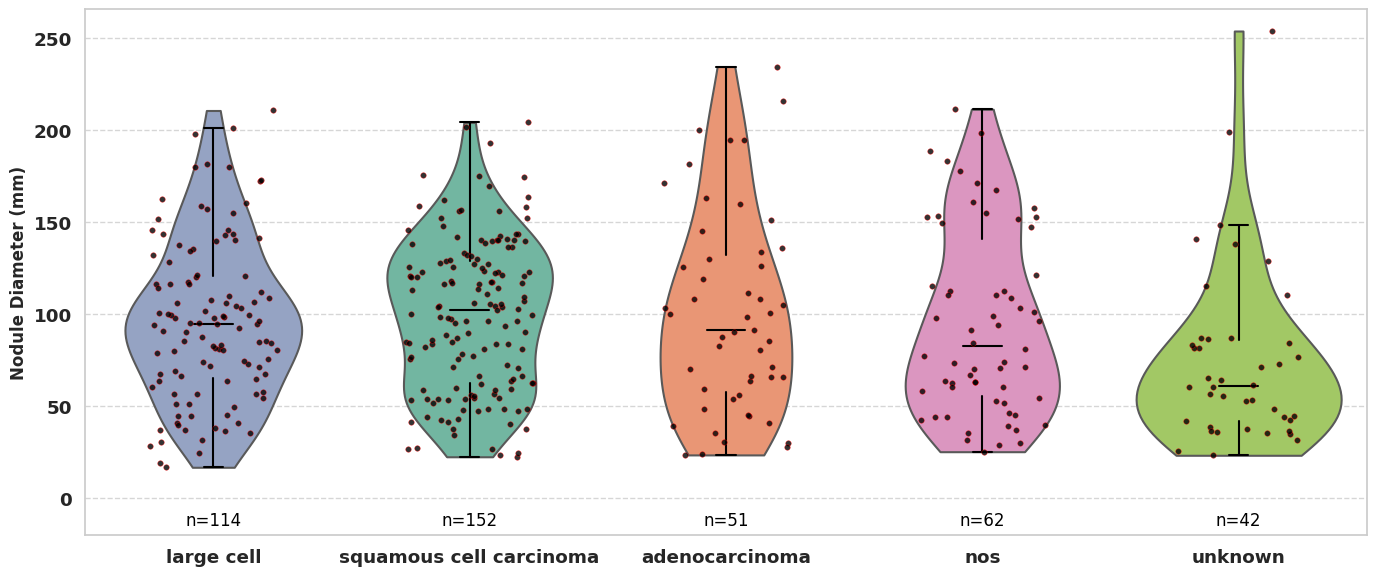

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Load and prepare data
df_boxes = pd.read_csv("NSCLC_bounding_boxes_annotations.csv")
df_clinical = pd.read_csv("NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv")

df_boxes.columns = df_boxes.columns.str.lower()
df_clinical.columns = df_clinical.columns.str.lower()
df = pd.merge(df_boxes, df_clinical, left_on="patient", right_on="patientid", how="inner")
df["histology"] = df["histology"].fillna("unknown")
df["diameter_mm"] = np.sqrt(df["w"]**2 + df["h"]**2 + df["d"]**2)

# Define custom color palette
palette = {
    "squamous cell carcinoma": "#66c2a5",
    "adenocarcinoma": "#fc8d62",
    "large cell": "#8da0cb",
    "nos": "#e78ac3",
    "unknown": "#a6d854"
}

# Plot setup
sns.set(style="whitegrid", font_scale=1.2, rc={"figure.dpi": 100})
plt.figure(figsize=(14, 6))

# Violin plot
sns.violinplot(
    data=df, x="histology", y="diameter_mm",
    palette=palette, inner=None, cut=0
)

# Box plot
sns.boxplot(
    data=df, x="histology", y="diameter_mm",
    width=0.15, palette=palette, fliersize=0,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.2),
    medianprops=dict(color='black', linewidth=1.5),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)

# Dots (stripplot)
sns.stripplot(
    data=df, x="histology", y="diameter_mm",
    color='black', jitter=0.25, alpha=0.8, size=4,
    edgecolor="red", linewidth=0.3
)

# Annotate counts
for i, hist in enumerate(df["histology"].unique()):
    count = df[df["histology"] == hist].shape[0]
    plt.text(i, -15, f'n={count}', ha='center', fontsize=12, color='black')

# Labels and polish
#plt.title("Nodule Size Distribution by Histology Type", fontsize=16, weight='bold')
plt.xlabel("")
plt.ylabel("Nodule Diameter (mm)", fontsize=12,weight='bold')
plt.xticks(rotation=0,weight='bold')
plt.yticks(rotation=0,weight='bold')
plt.ylim(bottom=-20)  # leave space for count annotations
plt.grid(axis='y', linestyle='--', alpha=0.8)

# Optional: tighter layout and save
plt.tight_layout()
plt.savefig("violin_nodule_size_by_histology.png", dpi=300)
plt.show()


# Let make an input Embadding json file

In [45]:
import os 
import json

data_dir = '/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_Radiomics_NIFTI_resampled/'



nifti_List = [f for f in os.listdir(data_dir) if f.endswith('.nii.gz')]
nifti_data_dict={}
training_nifti_lst = []


for ct in nifti_List:
    training_nifti_lst.append({"image": "NSCLC_Radiomics_NIFTI_resampled/"+ct})

training_nifti_lst


dataset_dict = {
    "name": "Experiments_NSCLCRadiomics_512xy_256z_111p25m",
    "description": "NSCLCRadiomics Dataset",
    "tensorImageSize": "3D",
    "file_ending": ".nii.gz",
    "channel_names": {
        "0": "CT"
    },

    "numTraining": len(training_nifti_lst),
    "training": training_nifti_lst

}

with open("Experiments_NSCLCRadiomics_512xy_256z_111p25m.json","w") as f:
    json.dump(dataset_dict,f, indent=4)
    

# Table---1

In [2]:
# === Radiology-Style Clinical Summary Table: NSCLC Dataset with Staging ===
import pandas as pd
from tabulate import tabulate

# Load dataset splits
df_train = pd.read_csv("NSCLCRadiomics_train_split.csv")
df_val = pd.read_csv("NSCLCRadiomics_validation_split.csv")
df_test = pd.read_csv("NSCLCRadiomics_test_split.csv")

# Assign split labels
df_train["Split"] = "Train"
df_val["Split"] = "Validation"
df_test["Split"] = "Test"

# Combine all data
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Helper to format counts and percentages
def fmt(val, total):
    return f"{val} ({(val / total * 100):.2f}%)"

# Patient and scan counts
patient_counts = df_all.groupby("Split")["patientid"].nunique()
scan_counts = df_all.groupby("Split")["patientid"].count()
total_patients = df_all["patientid"].nunique()
total_scans = df_all["patientid"].count()

summary = [
    {"Category": "Patient", "Value": "Unique Patients",
     "Total": fmt(total_patients, total_patients),
     "Train": fmt(patient_counts["Train"], total_patients),
     "Validation": fmt(patient_counts["Validation"], total_patients),
     "Test": fmt(patient_counts["Test"], total_patients)},

    {"Category": "CT", "Value": "Unique CT scans",
     "Total": fmt(total_scans, total_scans),
     "Train": fmt(scan_counts["Train"], total_scans),
     "Validation": fmt(scan_counts["Validation"], total_scans),
     "Test": fmt(scan_counts["Test"], total_scans)}
]

# Age summary
df_all["age"] = pd.to_numeric(df_all["age"], errors="coerce")
age_stats = df_all.groupby("Split")["age"].agg(["mean", "std"]).round(1)
age_stats["summary"] = age_stats["mean"].astype(str) + " ± " + age_stats["std"].astype(str)
age_total = f"{df_all['age'].mean():.1f} ± {df_all['age'].std():.1f}"

summary.append({
    "Category": "Age (years)", "Value": "Mean ± SD",
    "Total": age_total,
    "Train": age_stats.loc["Train", "summary"],
    "Validation": age_stats.loc["Validation", "summary"],
    "Test": age_stats.loc["Test", "summary"]
})

# Gender rows
gender_counts = df_all.groupby(["Split", "gender"]).size().unstack().fillna(0).astype(int)
gender_total = df_all["gender"].value_counts().reindex(["female", "male"]).fillna(0).astype(int)

for gender in ["female", "male"]:
    row = {
        "Category": "Gender", "Value": gender.capitalize(),
        "Total": fmt(gender_total[gender], len(df_all)),
        "Train": fmt(gender_counts.loc["Train", gender], len(df_all[df_all["Split"] == "Train"])),
        "Validation": fmt(gender_counts.loc["Validation", gender], len(df_all[df_all["Split"] == "Validation"])),
        "Test": fmt(gender_counts.loc["Test", gender], len(df_all[df_all["Split"] == "Test"]))
    }
    summary.append(row)

# Function to compute categorical distributions
def build_stage_rows(df, column, label):
    stage_counts = df.groupby(["Split", column]).size().unstack().fillna(0).astype(int)
    total_counts = df[column].value_counts().sort_index()

    rows = []
    for stage in sorted(total_counts.index):
        row = {
            "Category": label,
            "Value": str(stage),
            "Total": fmt(total_counts[stage], len(df))
        }
        for split in ["Train", "Validation", "Test"]:
            split_total = len(df[df["Split"] == split])
            count = stage_counts.loc[split][stage] if stage in stage_counts.loc[split] else 0
            row[split] = fmt(count, split_total)
        rows.append(row)
    return rows

# Add T, N, M, and Overall stage rows
summary += build_stage_rows(df_all, "overall.stage", "Overall Stage")
summary += build_stage_rows(df_all, "clinical.t.stage", "T Stage")
summary += build_stage_rows(df_all, "clinical.n.stage", "N Stage")
summary += build_stage_rows(df_all, "clinical.m.stage", "M Stage")

# Final DataFrame
df_summary = pd.DataFrame(summary)[["Category", "Value", "Total", "Train", "Validation", "Test"]]

# Display table
print(tabulate(df_summary, headers="keys", tablefmt="grid"))


+----+---------------+-----------------+---------------+--------------+--------------+-------------+
|    | Category      | Value           | Total         | Train        | Validation   | Test        |
+====+===============+=================+===============+==============+==============+=============+
|  0 | Patient       | Unique Patients | 421 (100.00%) | 334 (79.33%) | 41 (9.74%)   | 46 (10.93%) |
+----+---------------+-----------------+---------------+--------------+--------------+-------------+
|  1 | CT            | Unique CT scans | 421 (100.00%) | 334 (79.33%) | 41 (9.74%)   | 46 (10.93%) |
+----+---------------+-----------------+---------------+--------------+--------------+-------------+
|  2 | Age (years)   | Mean ± SD       | 68.0 ± 10.1   | 68.0 ± 9.9   | 68.7 ± 10.8  | 67.5 ± 11.0 |
+----+---------------+-----------------+---------------+--------------+--------------+-------------+
|  3 | Gender        | Female          | 131 (31.12%)  | 111 (33.23%) | 11 (26.83%)  | 9 (1

In [9]:
# === Radiology-Style Clinical Summary Table: NSCLC Dataset with Staging and Nodule Metrics ===
import pandas as pd
import numpy as np
from tabulate import tabulate

# Load dataset splits
df_train = pd.read_csv("NSCLCRadiomics_train_split.csv")
df_val = pd.read_csv("NSCLCRadiomics_validation_split.csv")
df_test = pd.read_csv("NSCLCRadiomics_test_split.csv")

# Assign split labels
df_train["Split"] = "Train"
df_val["Split"] = "Validation"
df_test["Split"] = "Test"

# Combine clinical metadata
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

df_all["diameter_mm"] = np.sqrt(df_all["w"]**2 + df_all["h"]**2 + df_all["d"]**2)



# Helper for formatting counts and percentages
def fmt(val, total):
    return f"{val} ({(val / total * 100):.2f}%)"

# Count patients and scans
patient_counts = df_all.groupby("Split")["patientid"].nunique()
scan_counts = df_all.groupby("Split")["patientid"].count()
total_patients = df_all["patientid"].nunique()
total_scans = df_all["patientid"].count()

summary = [
    {"Category": "Patient", "Value": "Unique Patients",
     "Total": fmt(total_patients, total_patients),
     "Train": fmt(patient_counts["Train"], total_patients),
     "Validation": fmt(patient_counts["Validation"], total_patients),
     "Test": fmt(patient_counts["Test"], total_patients)},

    {"Category": "CT", "Value": "Unique CT scans",
     "Total": fmt(total_scans, total_scans),
     "Train": fmt(scan_counts["Train"], total_scans),
     "Validation": fmt(scan_counts["Validation"], total_scans),
     "Test": fmt(scan_counts["Test"], total_scans)}
]

# Age summary
df_all["age"] = pd.to_numeric(df_all["age"], errors="coerce")
age_stats = df_all.groupby("Split")["age"].agg(["mean", "std"]).round(1)
age_stats["summary"] = age_stats["mean"].astype(str) + " ± " + age_stats["std"].astype(str)
age_total = f"{df_all['age'].mean():.1f} ± {df_all['age'].std():.1f}"

summary.append({
    "Category": "Age (years)", "Value": "Mean ± SD",
    "Total": age_total,
    "Train": age_stats.loc["Train", "summary"],
    "Validation": age_stats.loc["Validation", "summary"],
    "Test": age_stats.loc["Test", "summary"]
})

# Gender breakdown
gender_counts = df_all.groupby(["Split", "gender"]).size().unstack().fillna(0).astype(int)
gender_total = df_all["gender"].value_counts().reindex(["female", "male"]).fillna(0).astype(int)
for gender in ["female", "male"]:
    row = {
        "Category": "Gender", "Value": gender.capitalize(),
        "Total": fmt(gender_total[gender], len(df_all)),
        "Train": fmt(gender_counts.loc["Train", gender], len(df_all[df_all["Split"] == "Train"])),
        "Validation": fmt(gender_counts.loc["Validation", gender], len(df_all[df_all["Split"] == "Validation"])),
        "Test": fmt(gender_counts.loc["Test", gender], len(df_all[df_all["Split"] == "Test"]))
    }
    summary.append(row)

# Staging rows
def build_stage_rows(df, column, label):
    stage_counts = df.groupby(["Split", column]).size().unstack().fillna(0).astype(int)
    total_counts = df[column].value_counts().sort_index()
    rows = []
    for stage in sorted(total_counts.index):
        row = {
            "Category": label,
            "Value": str(stage),
            "Total": fmt(total_counts[stage], len(df))
        }
        for split in ["Train", "Validation", "Test"]:
            split_total = len(df[df["Split"] == split])
            count = stage_counts.loc[split][stage] if stage in stage_counts.loc[split] else 0
            row[split] = fmt(count, split_total)
        rows.append(row)
    return rows

summary += build_stage_rows(df_all, "overall.stage", "Overall Stage")
summary += build_stage_rows(df_all, "clinical.t.stage", "T Stage")
summary += build_stage_rows(df_all, "clinical.n.stage", "N Stage")
summary += build_stage_rows(df_all, "clinical.m.stage", "M Stage")
summary += build_stage_rows(df_all, "histology", "Histology")

# Nodule statistics
nodule_counts = df_all.groupby("Split").size()
nodule_total = len(df_all)
diameter_stats = df_all.groupby("Split")["diameter_mm"].agg(["mean", "std"]).round(1)
diameter_total = f"{df_all['diameter_mm'].mean():.1f} ± {df_all['diameter_mm'].std():.1f}"
diameter_stats["summary"] = diameter_stats["mean"].astype(str) + " ± " + diameter_stats["std"].astype(str)

summary.append({
    "Category": "Nodule", "Value": "Annotation Count",
    "Total": fmt(nodule_total, nodule_total),
    "Train": fmt(nodule_counts.get("Train", 0), nodule_total),
    "Validation": fmt(nodule_counts.get("Validation", 0), nodule_total),
    "Test": fmt(nodule_counts.get("Test", 0), nodule_total)
})

summary.append({
    "Category": "Nodule", "Value": "Mean ± SD Diameter (mm)",
    "Total": diameter_total,
    "Train": diameter_stats.loc["Train", "summary"] if "Train" in diameter_stats.index else "--",
    "Validation": diameter_stats.loc["Validation", "summary"] if "Validation" in diameter_stats.index else "--",
    "Test": diameter_stats.loc["Test", "summary"] if "Test" in diameter_stats.index else "--"
})

# Build final summary table
df_summary = pd.DataFrame(summary)[["Category", "Value", "Total", "Train", "Validation", "Test"]]

# Display
print(tabulate(df_summary, headers="keys", tablefmt="grid"))


+----+---------------+-------------------------+---------------+--------------+--------------+-------------+
|    | Category      | Value                   | Total         | Train        | Validation   | Test        |
+====+===============+=========================+===============+==============+==============+=============+
|  0 | Patient       | Unique Patients         | 421 (100.00%) | 334 (79.33%) | 41 (9.74%)   | 46 (10.93%) |
+----+---------------+-------------------------+---------------+--------------+--------------+-------------+
|  1 | CT            | Unique CT scans         | 421 (100.00%) | 334 (79.33%) | 41 (9.74%)   | 46 (10.93%) |
+----+---------------+-------------------------+---------------+--------------+--------------+-------------+
|  2 | Age (years)   | Mean ± SD               | 68.0 ± 10.1   | 68.0 ± 9.9   | 68.7 ± 10.8  | 67.5 ± 11.0 |
+----+---------------+-------------------------+---------------+--------------+--------------+-------------+
|  3 | Gender      

In [7]:
df_train['histology']

,patient,ct_path,seg_path,label,coordx,coordy,coordz,w,h,d,...,clinical.t.stage,clinical.n.stage,clinical.m.stage,overall.stage,histology,gender,survival.time,deadstatus.event,fitSplit,Split
0,LUNG1-089,LUNG1-089/NSCLC_089_0000.nii.gz,LUNG1-089/seg-GTV-1.nii.gz,1,56.666000,-42.988000,-490.900024,12.701000,16.609000,12.000004,...,1.0,3,0,IIIb,adenocarcinoma,female,1517,0,train,Train
1,LUNG1-415,LUNG1-415/NSCLC_415_0000.nii.gz,LUNG1-415/seg-GTV-1.nii.gz,1,-87.402344,-214.644531,-436.500000,12.695312,16.601562,18.000000,...,1.0,0,0,I,adenocarcinoma,female,2517,1,train,Train
2,LUNG1-041,LUNG1-041/NSCLC_041_0000.nii.gz,LUNG1-041/seg-GTV-1.nii.gz,1,-42.988000,0.000000,-513.000000,62.528000,46.896000,45.000000,...,1.0,0,0,I,adenocarcinoma,female,136,1,train,Train
3,LUNG1-411,LUNG1-411/NSCLC_411_0000.nii.gz,LUNG1-411/seg-GTV-1.nii.gz,1,53.222656,-123.683594,-490.000000,33.203125,26.367188,33.000000,...,2.0,2,0,IIIa,adenocarcinoma,female,583,1,train,Train
4,LUNG1-034,LUNG1-034/NSCLC_034_0000.nii.gz,LUNG1-034/seg-GTV-1.nii.gz,1,68.390000,-38.103000,-512.900024,67.413000,69.367000,69.000022,...,3.0,3,0,IIIb,adenocarcinoma,male,597,1,train,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,LUNG1-161,LUNG1-161/NSCLC_161_0000.nii.gz,LUNG1-161/seg-GTV-1.nii.gz,1,-101.074203,63.964859,-510.000000,15.625000,14.648438,9.000000,...,1.0,0,0,I,unknown,male,754,1,train,Train
330,LUNG1-066,LUNG1-066/NSCLC_066_0000.nii.gz,LUNG1-066/seg-GTV-1.nii.gz,1,-39.080000,52.758000,-563.400024,31.264000,37.126000,42.000013,...,4.0,2,0,IIIb,unknown,male,498,1,train,Train
331,LUNG1-111,LUNG1-111/NSCLC_111_0000.nii.gz,LUNG1-111/seg-GTV-1.nii.gz,1,-68.847641,49.316422,-466.900024,16.601562,22.460938,15.000000,...,1.0,0,0,I,unknown,male,426,1,train,Train
332,LUNG1-260,LUNG1-260/NSCLC_260_0000.nii.gz,LUNG1-260/seg-GTV-1.nii.gz,1,69.824219,-146.871094,-445.500000,31.250000,39.062500,42.000000,...,1.0,0,0,I,unknown,male,529,1,train,Train


In [20]:
segmented_data_df.columns

Index(['Vista3DSegNifti', 'patient', 'ct_path', 'seg_path', 'label', 'coordx',
       'coordy', 'coordz', 'w', 'h', 'd', 'patientid', 'age',
       'clinical.t.stage', 'clinical.n.stage', 'clinical.m.stage',
       'overall.stage', 'histology', 'gender', 'survival.time',
       'deadstatus.event', 'fitSplit', 'Split', 'diameter_mm'],
      dtype='object')

In [34]:
segmented_data_df_filtered['histology'].value_counts()

squamous cell carcinoma    151
large cell                 113
adenocarcinoma              51
Name: histology, dtype: int64

# Detection

In [1]:
import json 
import pandas as pd


reject_list = {
    "validation": {
        "SAMPLE_2017", "SAMPLE_1998", "SAMPLE_2005", "SAMPLE_0095", "SAMPLE_1508", "SAMPLE_1633"
    },
    "testing": {
        "SAMPLE_2009", "SAMPLE_2019", "SAMPLE_2022", "SAMPLE_2014", "SAMPLE_2026", "SAMPLE_2015", "SAMPLE_0217"
    },
    "training": {
        "SAMPLE_2023", "SAMPLE_2018", "SAMPLE_2016", "SAMPLE_2011", "SAMPLE_2000", "SAMPLE_2032", "SAMPLE_1999",
        "SAMPLE_2010", "SAMPLE_2025", "SAMPLE_1996", "SAMPLE_0065", "SAMPLE_2008", "SAMPLE_2002", "SAMPLE_2021",
        "SAMPLE_2003", "SAMPLE_0525", "SAMPLE_1994", "SAMPLE_1993", "SAMPLE_2020", "SAMPLE_2027", "SAMPLE_1794",
        "SAMPLE_1837", "SAMPLE_1640", "SAMPLE_1574", "SAMPLE_1857", "SAMPLE_1564", "SAMPLE_1596", "SAMPLE_1856",
        "SAMPLE_1570", "SAMPLE_1579", "SAMPLE_1620", "SAMPLE_1643", "SAMPLE_1644", "SAMPLE_1561"
    }
}




inferenceNSCLCRadiomicsTR    = pd.read_csv('NSCLCRadiomics_train_split.csv')
inferenceNSCLCRadiomicsTR_ct = inferenceNSCLCRadiomicsTR['patient'].unique()

dictlist_NSCLCRadiomicsTR =[]
for sir_uid in range(0,len(inferenceNSCLCRadiomicsTR_ct)):
    
    if sir_uid not in reject_list["training"]:
        i_dict={}
        i_siruid_df = inferenceNSCLCRadiomicsTR[inferenceNSCLCRadiomicsTR['patient']==inferenceNSCLCRadiomicsTR_ct[sir_uid]].reset_index()
        img_name = i_siruid_df['ct_path'][0].split('/')[-1]

        box_j     =[]
        lbl_box_j =[]
        for j in range(0,len(i_siruid_df)):
            
            box_j.append([i_siruid_df.iloc[j].coordx,
                             i_siruid_df.iloc[j].coordy,
                             i_siruid_df.iloc[j].coordz,
                             i_siruid_df.iloc[j].w,
                             i_siruid_df.iloc[j].h,
                             i_siruid_df.iloc[j].d])
            lbl_box_j.append(0)

        i_dict['image'] = 'NSCLC_Radiomics_NIFTI_resampled/'+img_name
        i_dict['box']   = box_j
        i_dict['label'] = lbl_box_j
        dictlist_NSCLCRadiomicsTR.append(i_dict)
            



inferenceNSCLCRadiomicsVal    = pd.read_csv('NSCLCRadiomics_validation_split.csv')
inferenceNSCLCRadiomicsVal_ct = inferenceNSCLCRadiomicsVal['patient'].unique()

dictlist_NSCLCRadiomicsVal =[]
for sir_uid in range(0,len(inferenceNSCLCRadiomicsVal_ct)):
    
    if sir_uid not in reject_list["validation"]:
        i_dict={}
        
        i_siruid_df = inferenceNSCLCRadiomicsVal[inferenceNSCLCRadiomicsVal['patient']==inferenceNSCLCRadiomicsVal_ct[sir_uid]].reset_index()
        img_name = i_siruid_df['ct_path'][0].split('/')[-1]

        box_j     =[]
        lbl_box_j =[]
        for j in range(0,len(i_siruid_df)):
            
            box_j.append([i_siruid_df.iloc[j].coordx,
                             i_siruid_df.iloc[j].coordy,
                             i_siruid_df.iloc[j].coordz,
                             i_siruid_df.iloc[j].w,
                             i_siruid_df.iloc[j].h,
                             i_siruid_df.iloc[j].d])
            lbl_box_j.append(0)

        i_dict['image'] = 'NSCLC_Radiomics_NIFTI_resampled/'+img_name
        i_dict['box']   = box_j
        i_dict['label'] = lbl_box_j
        dictlist_NSCLCRadiomicsVal.append(i_dict)


inferenceNSCLCRadiomicsTS    = pd.read_csv('NSCLCRadiomics_test_split.csv')
inferenceNSCLCRadiomicsTS_ct = inferenceNSCLCRadiomicsTS['patient'].unique()

dictlist_NSCLCRadiomicsTS =[]
for sir_uid in range(0,len(inferenceNSCLCRadiomicsTS_ct)):
    
    if sir_uid not in reject_list["training"]:
        i_dict={}
        
        i_siruid_df = inferenceNSCLCRadiomicsTS[inferenceNSCLCRadiomicsTS['patient']==inferenceNSCLCRadiomicsTS_ct[sir_uid]].reset_index()
        img_name = i_siruid_df['ct_path'][0].split('/')[-1]


        box_j     =[]
        lbl_box_j =[]
        for j in range(0,len(i_siruid_df)):
            
            box_j.append([i_siruid_df.iloc[j].coordx,
                             i_siruid_df.iloc[j].coordy,
                             i_siruid_df.iloc[j].coordz,
                             i_siruid_df.iloc[j].w,
                             i_siruid_df.iloc[j].h,
                             i_siruid_df.iloc[j].d])
            lbl_box_j.append(0)

        i_dict['image'] = 'NSCLC_Radiomics_NIFTI_resampled/'+img_name
        i_dict['box']   = box_j
        i_dict['label'] = lbl_box_j
        dictlist_NSCLCRadiomicsTS.append(i_dict)
        
        
        
dataset_discriptor_dict = {
    "name": "NSCLCRadiomics Detection Dataset",
    "numTraining": len(dictlist_NSCLCRadiomicsTR),
    "numValidation": len(dictlist_NSCLCRadiomicsVal),
    "numTest": len(dictlist_NSCLCRadiomicsTS),
    "training":dictlist_NSCLCRadiomicsTR,
    "validation":dictlist_NSCLCRadiomicsVal,
    "testing":dictlist_NSCLCRadiomicsTS}


NSCLCRadiomics_fold1_json = 'NSCLCRadiomics_fold1.json'
with open(NSCLCRadiomics_fold1_json, 'w') as file: json.dump(dataset_discriptor_dict, file, indent=4)

# Classification-Daignostic

In [3]:
import pandas as pd
import numpy as np
# Load dataset splits
df_train = pd.read_csv("NSCLCRadiomics_train_split.csv")
df_val   = pd.read_csv("NSCLCRadiomics_validation_split.csv")
df_test  = pd.read_csv("NSCLCRadiomics_test_split.csv")

# Assign split labels
df_train["Split"] = "Train"
df_val["Split"]   = "Validation"
df_test["Split"]  = "Test"

# Combine clinical metadata
df_all                = pd.concat([df_train, df_val, df_test], ignore_index=True)
df_all
df_all['nifti_name']      = df_all['ct_path'].str.split('/').str[-1]
df_all['lesion_level_GT'] = df_all['label']


def assign_annotation_ids(group):
    group['annotation-idx'] = [f"{str(i+1).zfill(2)}" for i in range(len(group))]
    return group

df_all                            = df_all.groupby('nifti_name').apply(assign_annotation_ids)
df_all['UNIQUE_ANNOTATION_ID']    = df_all['ct_path'].str.split('/').str[-1].str.split('.nii.gz').str[0]+'_'+df_all['annotation-idx']
df_all['coordX']=df_all['coordx']
df_all['coordY']=df_all['coordy']
df_all['coordZ']=df_all['coordz']


df_all['UNIQUE_ANNOTATION_ID_nifti'] = df_all['UNIQUE_ANNOTATION_ID']+'.nii.gz'
df_all.to_csv('NSCLCRadiomics_bounding_boxes_annotations_metadata_trvalts.csv',index=False,encoding='utf-8')
df_all

df_all.to_csv('/NAS/shared_data/for_VNLST/ft42/ct_public/NSCLC_Radiomics_Dataset/manifest-1603198545583/NSCLC_images_resampled_diagnostic_64Q_patches/NSCLCRadiomics_bounding_boxes_annotations_metadata_trvalts.csv',index=False,encoding='utf-8')

/tmp/ipykernel_1926615/1789720285.py:24: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_all                            = df_all.groupby('nifti_name').apply(assign_annotation_ids)


# Distributation

In [1]:
# === Radiology-Style Clinical Summary Table: NSCLC Dataset with Staging and Nodule Metrics ===
import pandas as pd
import numpy as np
from tabulate import tabulate

# Load dataset splits
df_train = pd.read_csv("NSCLCRadiomics_train_split.csv")
df_val = pd.read_csv("NSCLCRadiomics_validation_split.csv")
df_test = pd.read_csv("NSCLCRadiomics_test_split.csv")

# Assign split labels
df_train["Split"] = "Train"
df_val["Split"] = "Validation"
df_test["Split"] = "Test"

# Combine clinical metadata
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

df_all["diameter_mm"] = np.sqrt(df_all["w"]**2 + df_all["h"]**2 + df_all["d"]**2)

df_all

,patient,ct_path,seg_path,label,coordx,coordy,coordz,w,h,d,...,clinical.n.stage,clinical.m.stage,overall.stage,histology,gender,survival.time,deadstatus.event,fitSplit,Split,diameter_mm
0,LUNG1-089,LUNG1-089/NSCLC_089_0000.nii.gz,LUNG1-089/seg-GTV-1.nii.gz,1,56.666000,-42.988000,-490.900024,12.701000,16.609000,12.000004,...,3,0,IIIb,adenocarcinoma,female,1517,0,train,Train,24.107558
1,LUNG1-415,LUNG1-415/NSCLC_415_0000.nii.gz,LUNG1-415/seg-GTV-1.nii.gz,1,-87.402344,-214.644531,-436.500000,12.695312,16.601562,18.000000,...,0,0,I,adenocarcinoma,female,2517,1,train,Train,27.582292
2,LUNG1-041,LUNG1-041/NSCLC_041_0000.nii.gz,LUNG1-041/seg-GTV-1.nii.gz,1,-42.988000,0.000000,-513.000000,62.528000,46.896000,45.000000,...,0,0,I,adenocarcinoma,female,136,1,train,Train,90.188611
3,LUNG1-411,LUNG1-411/NSCLC_411_0000.nii.gz,LUNG1-411/seg-GTV-1.nii.gz,1,53.222656,-123.683594,-490.000000,33.203125,26.367188,33.000000,...,2,0,IIIa,adenocarcinoma,female,583,1,train,Train,53.727796
4,LUNG1-034,LUNG1-034/NSCLC_034_0000.nii.gz,LUNG1-034/seg-GTV-1.nii.gz,1,68.390000,-38.103000,-512.900024,67.413000,69.367000,69.000022,...,3,0,IIIb,adenocarcinoma,male,597,1,train,Train,118.816229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,LUNG1-278,LUNG1-278/NSCLC_278_0000.nii.gz,LUNG1-278/seg-GTV-1.nii.gz,1,-66.894531,-143.589844,-424.000000,59.570312,36.132812,42.000000,...,0,0,II,unknown,male,527,1,test,Test,81.352334
417,LUNG1-100,LUNG1-100/NSCLC_100_0000.nii.gz,LUNG1-100/seg-GTV-1.nii.gz,1,73.730484,7.324234,-534.500000,23.437500,22.460938,15.000000,...,0,0,I,unknown,female,1474,0,test,Test,35.760455
418,LUNG1-394,LUNG1-394/NSCLC_394_0000.nii.gz,LUNG1-394/seg-GTV-1.nii.gz,1,-77.636719,-172.285156,-513.500000,56.640625,54.687500,36.000000,...,0,0,I,unknown,male,344,1,test,Test,86.572993
419,LUNG1-246,LUNG1-246/NSCLC_246_0000.nii.gz,LUNG1-246/seg-GTV-1.nii.gz,1,-41.503906,-142.683594,-124.065223,53.710938,38.085938,27.000000,...,3,0,IIIb,unknown,female,3521,0,test,Test,71.164622


/tmp/ipykernel_415/3882689597.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['Patients', 'CTs', 'Nodules'], rotation=0, ha='center')
/tmp/ipykernel_415/3882689597.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axs[1],


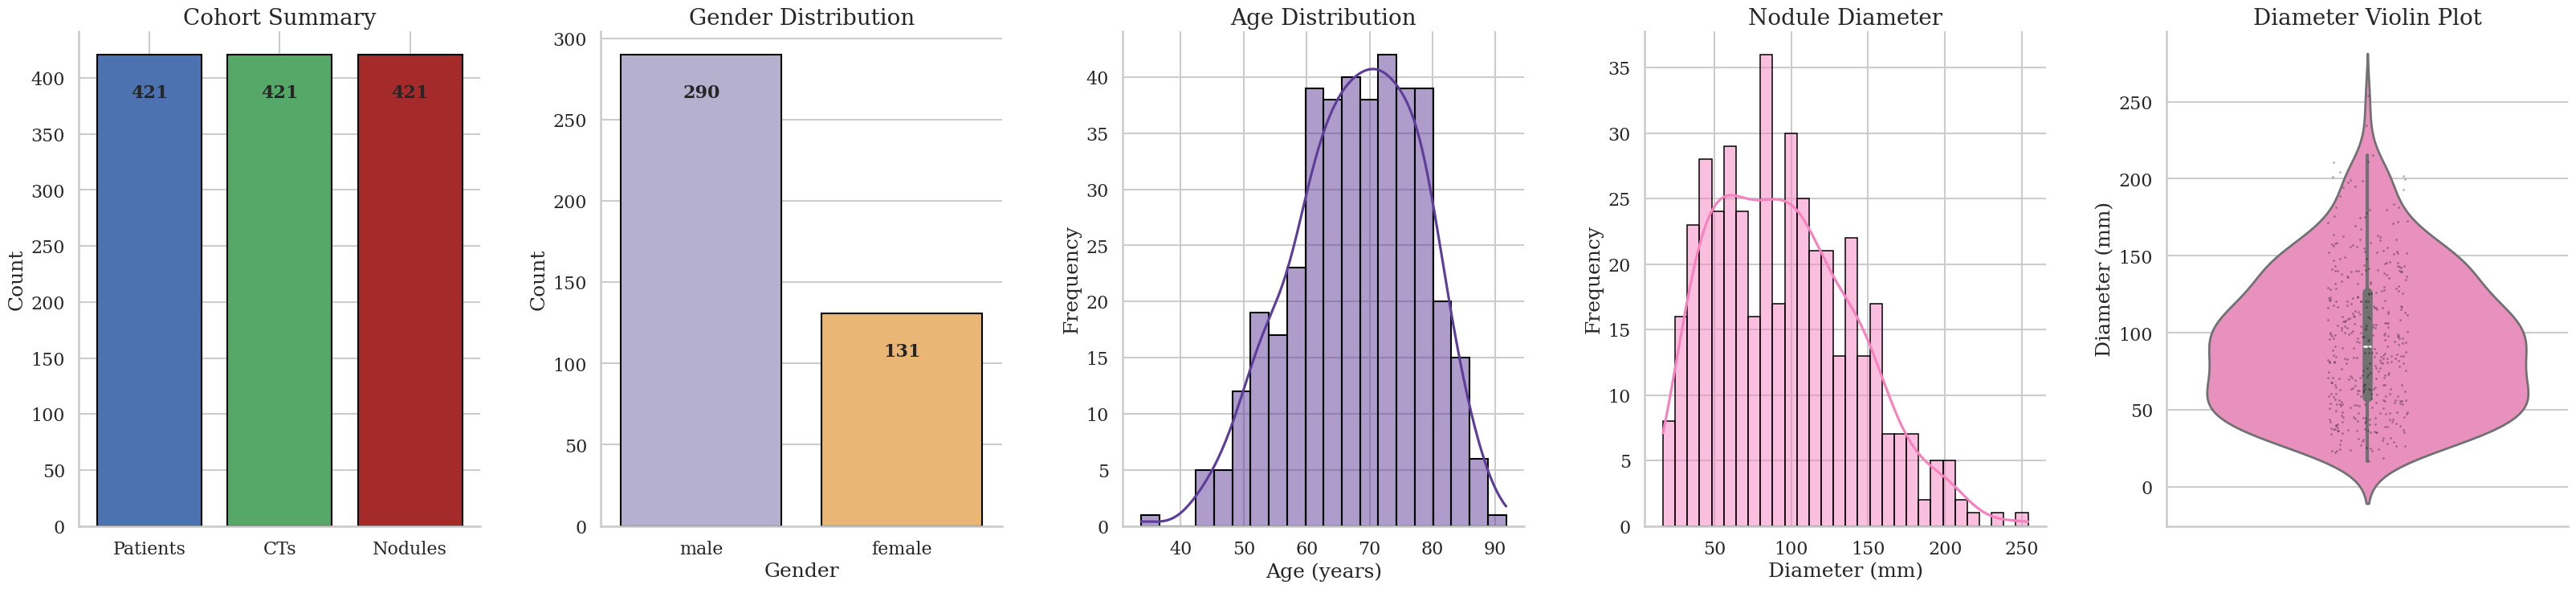

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set publication-ready style
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "figure.titlesize": 22
})

# Load dataset splits
df_train = pd.read_csv("NSCLCRadiomics_train_split.csv")
df_val = pd.read_csv("NSCLCRadiomics_validation_split.csv")
df_test = pd.read_csv("NSCLCRadiomics_test_split.csv")

# Assign split labels
df_train["Split"] = "Train"
df_val["Split"] = "Validation"
df_test["Split"] = "Test"

# Combine clinical metadata
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
df_all["diameter_mm"] = np.sqrt(df_all["w"]**2 + df_all["h"]**2 + df_all["d"]**2)

fig, axs = plt.subplots(1, 5, figsize=(40, 8))
plt.subplots_adjust(wspace=0.3)

# 1. Unique patients, CTs, and entries (annotations)
unique_patients = df_all['patient'].nunique()
unique_cts = df_all['ct_path'].nunique()
total_entries = len(df_all)

axs[0].bar(['Patients', 'CTs', 'Annotations'],
           [unique_patients, unique_cts, total_entries],
           color=['#4c72b0', '#55a868', 'brown'], edgecolor='black')
axs[0].set_title('Cohort Summary')
axs[0].set_ylabel('Count')
for i, v in enumerate([unique_patients, unique_cts, total_entries]):
    axs[0].text(i, v - max([unique_patients, unique_cts, total_entries]) * 0.10, str(v), 
                ha='center', va='bottom', fontsize=16, fontweight='bold')
axs[0].set_xticklabels(['Patients', 'CTs', 'Nodules'], rotation=0, ha='center')

# 2. Gender bar plot
gender_counts = df_all['gender'].value_counts()
sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axs[1], 
            palette=['#b2abd2', '#fdb863'], edgecolor='black')
axs[1].set_title('Gender Distribution')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Gender')
for i, v in enumerate(gender_counts.values):
    axs[1].text(i, v - gender_counts.max()* 0.10, str(v), 
                ha='center', va='bottom', fontsize=16, fontweight='bold')

# 3. Age distribution plot
sns.histplot(df_all['age'], bins=20, kde=True, ax=axs[2], color='#5e3c99', edgecolor='black')
axs[2].set_title('Age Distribution')
axs[2].set_xlabel('Age (years)')
axs[2].set_ylabel('Frequency')

# 4. Diameter_mm histogram (pink)
sns.histplot(df_all['diameter_mm'], bins=30, kde=True, ax=axs[3], color='#f781bf', edgecolor='black')
axs[3].set_title('Nodule Diameter')
axs[3].set_xlabel('Diameter (mm)')
axs[3].set_ylabel('Frequency')

# 5. Diameter_mm violin plot (pink)
sns.violinplot(y=df_all['diameter_mm'], ax=axs[4], color='#f781bf', linewidth=2)
axs[4].set_title('Diameter Violin Plot')
axs[4].set_xlabel('')
axs[4].set_ylabel('Diameter (mm)')



# Remove top/right spines for all plots for a cleaner look
for ax in axs:
    sns.despine(ax=ax, top=True, right=True)

#plt.suptitle('NSCLC Dataset: Clinical and Nodule Characteristics', fontsize=24, y=1.08, fontweight='bold')
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig("nsclc_publication_subplots.png", dpi=300, bbox_inches='tight')
sns.stripplot(y=df_all['diameter_mm'], ax=axs[4], color='k', size=2, alpha=0.3, jitter=True)
plt.show()